<a href="https://colab.research.google.com/github/virf96/Analisis_Texto/blob/master/text_embeddings_vgensim4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representaciones vectoriales de palabras y oraciones: text embeddings

### Procesamiento del Lenguaje Natural

**Pablo Martínez Olmos, Vanessa Gómez Verdejo,  Emilio Parrado Hernández**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

In [ ]:
%matplotlib inline  
# Figures plotted inside the notebook
%config InlineBackend.figure_format = 'retina'
# High quality figures
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc

# Configuración de las figuras matplotlib
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams.update({'font.size': 12})

# 1. Introducción

Un *embedding* es una representación vectorial de nuestros datos en un espacio de dimensión **relativamente bajo**. La representación mediante *embeddings* suele utilizarse para facilitar el aprendizaje de modelos cuando se tienen que manejar datos categóricos o conceptos cuya codificación suele llevar a representaciones *sparse* de alta dimensión, como pueden ser codificaciones one-hot encoding de variables categóricas estandar o  representaciones BoW o TF-IDF de documentos. 

Así, por ejemplo, una codificación one-hot de paises y ciudades nos llevaría a vectores de este tipo:

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/Embeddings/OneHotEncoding.png" width="40%"> 


Al utilizar este tipo de representaciones en un sistema de aprendizaje automático nos encontramos varias limitaciones:
* Por un lado, trabajar con un espacio de **muy alta dimensión** implica entrenar un modelo con muchos parámetros, lo que a su vez conlleva un mayor coste computacional, riesgo de sobreajuste, ...
* Por otro lado, el tener que manejar representaciones dispersas dificulta el cálculo de distancias entre elementos así como la **identificación de elementos similares**. Por ejemplo, la codificación anterior nos va a dar la misma distancia entre Rome y Paris que entre Rome e Italia.

Por tanto, para utilizar este tipo de representaciones en un sistema de aprendizaje automático, necesitamos una forma de representar cada vector disperso como un vector de números para el que los elementos semánticamente similares (ciudades, películas o palabras) tengan distancias similares en el espacio vectorial. La solución a estos problemas es utilizar *embeddings*, ya que son capaces de transformar grandes vectores dispersos a un espacio de menor dimensión que preserva las relaciones semánticas. 

Idealmente, un buen *embedding* debe proporcionar un conjunto de vectores cuya posición (distancia y dirección) en el espacio vectorial codifique la semántica de los datos que representan. Las siguientes visualizaciones$^{(*)}$ de *embeddings* reales muestran relaciones geométricas que capturan relaciones semánticas como el genero, un tiempo verbal o la relación entre un país y su capital

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/Embeddings/Embeddings1.svg" width="80%"> 

Además, la representación de los datos mediante  *embeddings* tiene varias ventajas:
* Ayuda al aprendizaje del modelo, ya que reducirá el coste computacional y evitará problemas de sobreajuste.  
* Esta representación puede aprenderse y reutilizarse en distintos modelos.
* Al manejar los datos en un espacio de menor dimensión se facilita su representación, ya sea porque el *embedding* nos permite tener los datos en un espacio de dos o tres dimensiones, o porque se puede combinar con algoritmos de visualización (que veremos más adelante) que nos permiten visualizar lo que está ocurriendo en este espacio del *embedding*.

$^{(*)}$ https://developers.google.com/machine-learning/crash-course/embeddings/translating-to-a-lower-dimensional-space


En la sesión de hoy, estudiaremos los siguientes aspectos relacionados con *embeddings* de texto:
- Modelo **Word2Vec** para entrenar *word embeddings*. 
    - Entrenamiento de Word2Vec con gensim. 
    - Modelos Word2Vec pre-entrenados en gensim y spaCy.
- **Técnicas de validación** de un diccionario de embeddings: visualización, word analogy, word semantic similarity, outlier detection.
- Otras aproximaciones a word embeddings: **CBoW, Glove, FastText**. Uso de modelos pre-entrenados.
- **Text embeddings (embeddings para documentos)**  con Doc2Vec y gensim.

# 2. Embeddings de palabras con Wor2Vec

[Word2vec](https://arxiv.org/pdf/1310.4546.pdf) utiliza un tipo muy sencillo de **red neuronal** para aprender asociaciones de palabras de un gran corpus de texto. Word2vec se basa en la premisa de que palabras con significado similar deben ser codificadas con vectores geométricamente cercanos. Para ello se considera que las palabras que suelen tener las mismas palabras vecinas (contexto) tienden a ser semánticamente similares. Tanto "perro" como "gato" aparecen con frecuencia cerca de la palabra "veterinario", y este hecho refleja su similitud semántica. 

Si bien en general vamos a utilizar librerías y modelos pre-entrenados, presentaremos wor2vec como ejemplo representativo de modelo de red neuronal aplicado a NLP. Para ello, revisamos brevemente **regresión logística para clasificación** y su extensión a Wor2Vec.

Hay diferentes esquemas para construir un word2vec, aquí vamos a ver el modelo más común que es el **Skip-Gram**.

## 2.1 Revisión: regresión logística binaria

Supongamos que tenemos un conjunto de datos de entrenamiento $(\mathbf{x}_i,y_i)$ donde $\mathbf{x}_i\in\mathbf{R}^m$ e $y_i\in\{0,1\}$.


En regresión logística (en adelante RL) aproximamos la probabilidad de la etiqueta $y$ usando una **combinación lineal** de las entradas $\bf x$:

$$P(y=1| {\bf x}) =  \frac{1}{1+\exp(-({\bf w}^T {\bf x}+w_0))}=\sigma({\bf w}^T {\bf x}+w_0)$$
$$$$
$$ P(y=0| {\bf x}) = 1- P(Y=y| {\bf x}) = 1 - \sigma({\bf w}^T {\bf x}+w_0)$$

donde 

- $w_0$ y ${\bf w} = [w_1, \ldots, w_D]$ son parámetros que aprenderemos usando el conjunto de datos de entrenamiento $(\mathbf{x}^{(i)},y^{(i)})_{i=1,\ldots,N}$.
$$$$
- $\sigma(a) = \frac{1}{1+\exp(-a)}$ es la función sigmoide.
$$$$


/var/folders/mp/m1pxr4954g9dg7ypdlqgrgl800029_/T/ipykernel_1090/3364570467.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
/var/folders/mp/m1pxr4954g9dg7ypdlqgrgl800029_/T/ipykernel_1090/3364570467.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='gray', alpha=0.2, ls='dotted', lw=1)


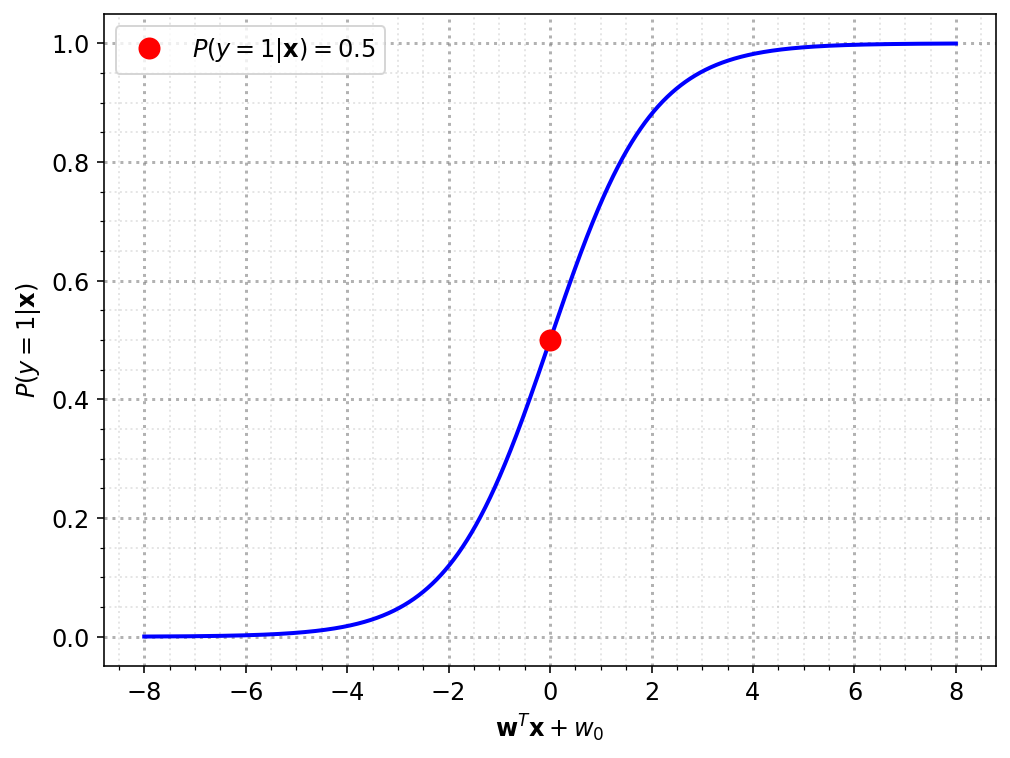

In [ ]:
# Ilustremos la función sigmoide

x = np.arange(-8,8,1e-3)

y = 1./(1+np.exp(-x))

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x,y,'-b',lw=2)
ax.plot(0,0.5,'or',ms=10,label=r'$P(y=1|\mathbf{x})=0.5$')
plt.xlabel('$\mathbf{w}^T\mathbf{x}+w_0$')
plt.ylabel('$P(y=1|\mathbf{x})$')
plt.legend()
#major grid lines
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
#minor grid lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='gray', alpha=0.2, ls='dotted', lw=1)

plt.show()

#### Función de coste

Para seleccionar el vector $\mathbf{w}$, RL resuelve el siguiente problema de optimización:

$$l({\bf w}) = \sum_{i=1}^N \left\lbrace  y^{(i)}\log \left(  P(y=1| {\bf x}^{(i)})\right)  + (1-y^{(i)}) \log\left(  1- P(y=1| {\bf x}^{(i)}) \right)  \right\rbrace $$

$${\bf w}^* =\displaystyle \underset{{\bf w}}{\operatorname{max}} l({\bf w})$$

- Que no es más que intentar alinear las regiones de probabilidades constantes con **las probabilidades de las etiquetas reales**.
- Este problema no tiene solución cerrada. Se resuelve con optimización numérica.

Vamos a cargar un ejemplo en 2D

In [ ]:
data_ejemplo1 = pd.read_csv('ejemplo1.txt',header=None)

data_ejemplo1.head(10)

0          1  2
0  34.623660  78.024693  1
1  30.286711  43.894998  0
2  35.847409  72.902198  0
3  60.182599  86.308552  1
4  79.032736  75.344376  1
5  45.083277  56.316372  0
6  61.106665  96.511426  1
7  75.024746  46.554014  1
8  76.098787  87.420570  1
9  84.432820  43.533393  1

A continuación cargamos y normalizamos los datos

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LR

data = np.array(data_ejemplo1)

## Dimensiones
dims=np.shape(data)
N=dims[0]

## Separamos X e Y
X01=data[:,0:2]
Y1=data[:,2]

# Separamos train de test
X01_train, X01_test, Y1_train, Y1_test = train_test_split(X01, Y1, test_size=0.2, random_state=0)

print("El conjunto de datos de entrenamiento consta {0:d} observaciones de {1:d} dimensiones\n".format(X01_train.shape[0], X01_train.shape[1]))

# Variables para la representación de la frontera de decisión (antes de normalizar!)
min1=np.min(X01_train[:,0])-1
max1=np.max(X01_train[:,0])+1
min2=np.min(X01_train[:,1])-1
max2=np.max(X01_train[:,1])+1

# Normalizamos los datos (media 0, varianza 1)

transformer1 = StandardScaler().fit(X01_train)   # X0 -->sin normalizar, X --> normalizadas

X1_train = transformer1.transform(X01_train)
X1_test = transformer1.transform(X01_test)

El conjunto de datos de entrenamiento consta 80 observaciones de 2 dimensiones



/var/folders/mp/m1pxr4954g9dg7ypdlqgrgl800029_/T/ipykernel_1090/111965417.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)


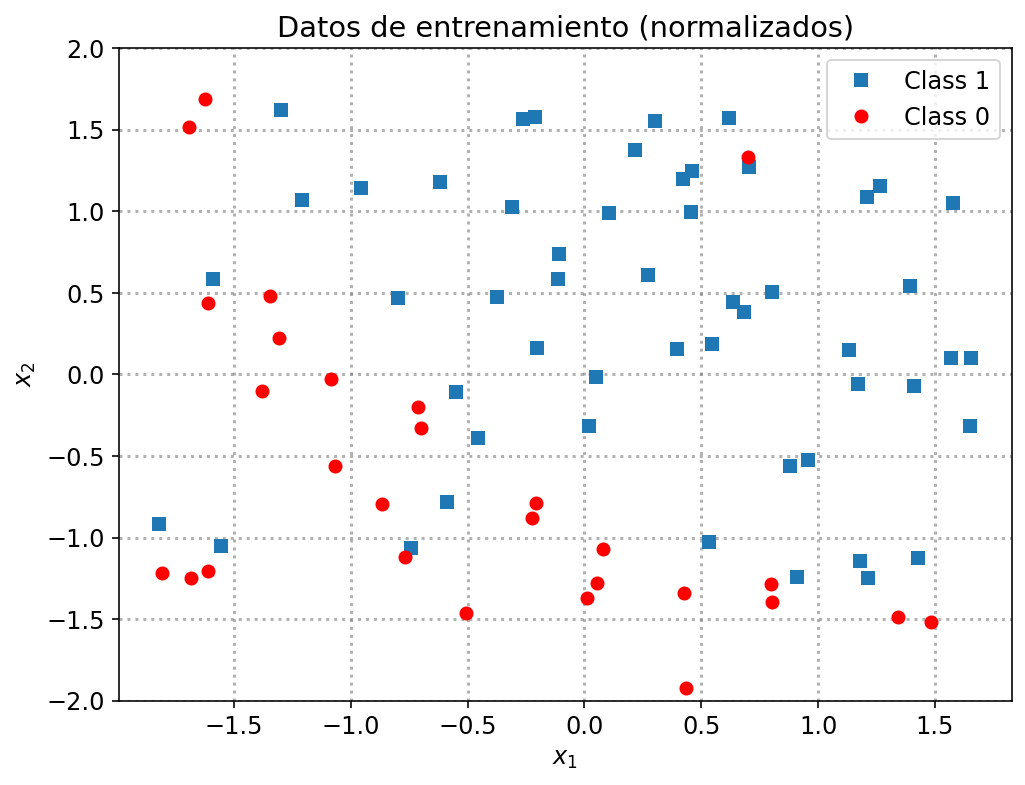

In [ ]:

plt.figure()

## Plot Training Data
index=(Y1_train==1)
plt.plot(X1_train[index,0],X1_train[index,1],'s',label="Class 1")
index=(Y1_train==0)
plt.plot(X1_train[index,0],X1_train[index,1],'ro',label="Class 0")
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.ylim([-2,2])
plt.grid(True)
plt.legend(loc='upper right')
plt.title('Datos de entrenamiento (normalizados)')
#major grid lines
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.show()


A continuación, entrenaremos un RL con los parámetros por defecto en sklearn (luego hablaremos del entrenamiento en sí  y qué parámetros nos ofrece la [implementación de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).

In [ ]:
mi_RL1 = LR()  

# Entrenamos el modelo
mi_RL1.fit(X1_train,Y1_train)


print("El vector w es")
print(mi_RL1.coef_)
print("Y el bias w0 es")
print(mi_RL1.intercept_)
print(f"El accuracy en los datos de entrenamiento es {mi_RL1.score(X1_train,Y1_train)}")
print(f"El accuracy en los datos de test es {mi_RL1.score(X1_test,Y1_test)}")

El vector w es
[[1.02723577 1.20105683]]
Y el bias w0 es
[0.8956994]
El accuracy en los datos de entrenamiento es 0.825
El accuracy en los datos de test es 0.95


Dibujemos los datos de test y la frontera de decisión

/var/folders/mp/m1pxr4954g9dg7ypdlqgrgl800029_/T/ipykernel_1090/1466660432.py:21: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)


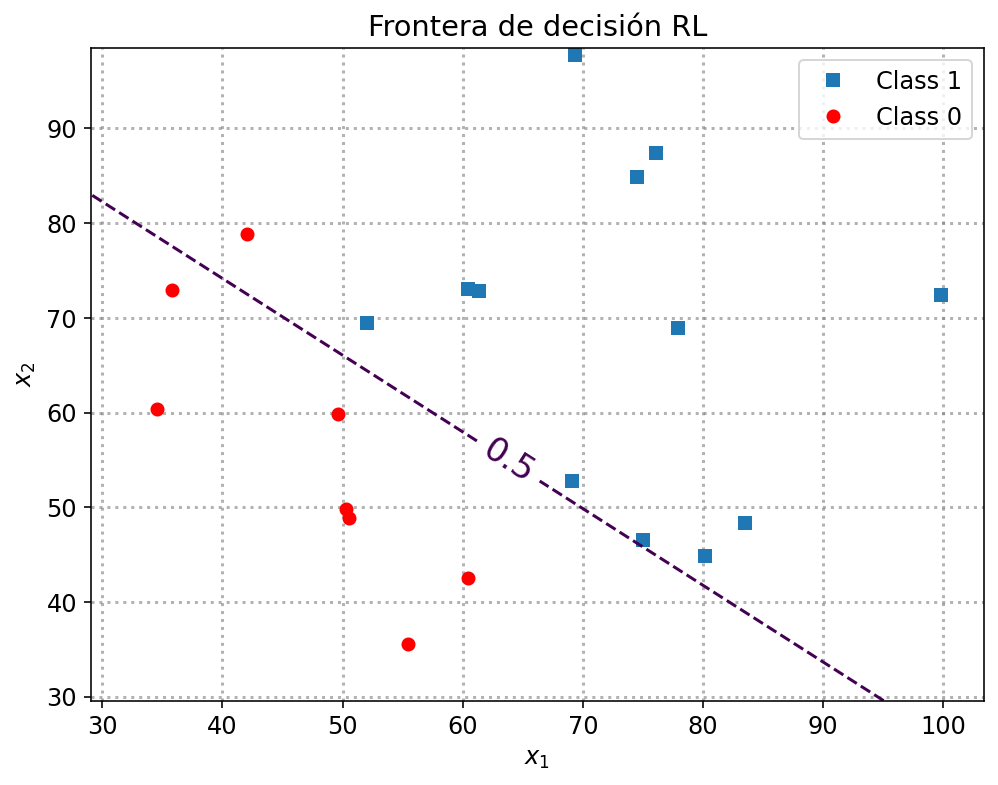

In [ ]:
# Obtenemos una rejilla de puntos en los que evaluaremos nuestro RL 
x1,x2 = np.mgrid[min1:max1:(max1-min1)/50, min2:max2:(max2-min2)/50]
grid = np.transpose(np.row_stack([x1.ravel(), x2.ravel()]))
# Normalizamos la rejilla
grid_norm = transformer1.transform(grid)

#Estimamos la probabilidad asociada a cada punto de la rejilla con el método .predic_proba
probs_LR1=mi_RL1.predict_proba(grid_norm)

fig, ax = plt.subplots()
## Plot Training Data
plt.plot(X01_test[Y1_test==1,0],X01_test[Y1_test==1,1],'s',label="Class 1")
plt.plot(X01_test[Y1_test==0,0],X01_test[Y1_test==0,1],'ro',label="Class 0")
cs = ax.contour(x1,x2,np.reshape(probs_LR1[:,1],np.shape(x1)),[0.5],linestyles='dashed')
ax.clabel(cs, inline=1, fontsize=17)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend(loc='upper right')
plt.title(r'Frontera de decisión RL')
#major grid lines
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.show()

## 2.2 Revisión: regresión logística multiclase

Supongamos ahora que tenemos etiquetas con $K$ posibles valores: $y_i \in\{1,\ldots,K\}$. RL formula ahora del siguiente modo:

\begin{align}
P(y=k|\mathbf{x}) = \frac{\text{e}^{z_k}}{\sum_{j=1}^{K}\text{e}^{z_j}}, k =1,\ldots,K
\end{align}
donde el vector $\mathbf{z} = \left[z_1,\ldots,z_K\right]$ se calcula como

$$\mathbf{z} = \mathbf{W}\mathbf{x} + \mathbf{w}_0$$

siendo $\mathbf{W}$ una matriz real de dimensiones $K\times m$ y $\mathbf{w_0}$ un vector de dimensiones $K \times 1$.

La función de coste es esencialmente la misma, acumulamos el logaritmo de la probabilidad que damos a cada etiqueta real:

$$l({\bf W,w_0}) = \sum_{i=1}^N \sum_{j=1}^{K} \log \left(  P(Y=k| {\bf x}^{(i)})\right) \mathbb{1}[y^{(i)}==k]$$


$${\bf W^*,w^*_0} =\displaystyle \underset{{\bf W,w_0}}{\operatorname{max}} l({\bf W,w_0})$$


## 2.3 Modelo Skip-Gram 

Supongamos que se tiene una ventana deslizante de tamaño fijo que se desplaza a lo largo de una frase: la palabra del centro es el **objetivo** y las que están a su izquierda y derecha dentro de la ventana deslizante son las palabras de **contexto**. 

Consideremos el siguiente ejemplo donde usamos una ventana de tamaño 5 para ir construyendo nuestras muestras de entrenamiento con pares de palabras (objetivo, contexto):

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/Embeddings/word2vec1.png" width="80%"> 

A partir de este conjunto de datos, el modelo Skip-Gram se entrena para predecir las probabilidades de que una palabra sea el contexto de un determinado objetivo. Para ello utiliza una **una regresión logística multiclase**, con la particularidad de que **la entrada al clasificador no es directamente la codificación one-hot** de cada palabra, sino un vector real de dimensión $D<<V$ que se aprende junto a los parámetros de la regresión logística. Este vector es el word embedding de dicha palabra. 

Al reducir la dimensión a la entrada, hacemos que el número de parámetros que tentemos que entrenar pase de **$V^2$ a $2D\times V$**. La estructura final, que mostramos a continuación, es un tipo de **red neuronal** muy sencilla.


<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/Embeddings/word2vec3.png" width="80%"> 

Las palabras objetivo ($x_1$, ..., $x_v$) están a la entrada de la red con una codificación one-hot. Las palabras contexto ($y_1$, ..., $y_v$) son el objetivo y están a la salida también con una codificación one-hot. De este modo la red, para cada par (objetivo, contexto) debe predecir el contexto de la palabra objetivo. Para ello, la red tiene una capa intermedia que permite modelar el contexto a partir del objetivo. El tamaño de esta capa ($D$) define el tamaño o dimensión de nuestro embedding; para procesado de texto suelen usarse embedding de tamaño 100, 200,... aunque lógicamente esto depende de la complejidad de la base de datos.

Usando así el conjunto de entrenamiento que generamos con el corpus de datos, se entrenará la red y se aprenderán los parámetros de red dados por las matrices de entrada $W$ y la de salida $W'$. Mientras que la matriz de salida codifica el contexto, la matriz de entrada (denominada *embedding*) nos da una representación en un espacio de tamaño $D$ de cada una de las palabras objetivo en nuestro corpus. 



## 2.4 Implementación de word2vec en Gensim

**NOTA IMPORTANTE**: Utilizamos gensim 4.0 o posterior. En aula global os dejo una versión compatible con gensim 3.X

Para diseñar un word2vec podemos usar la implementación de  [word2vec](https://radimrehurek.com/gensim/models/word2vec.html) que incluye la librería de gensim. Su uso es bastante sencillo ya que sólo necesita que le facilitemos una colección de frases (él se encarga de generar por nosotros los pares de palabras (objetivo, contexto)) y solo hay que indicarle algunos parámetros:
* `vector_size` (tamaño del embedding): el número de dimensiones que tendrá su representación vectorial. Por defecto es 100.
* `window` (tamaño de la ventana): el número de palabras adyacentes que se consideran en el mismo contexto de una palabra objetivo. Por defecto es 5.
* `sg` (algoritmo word2vec). Debemos indicat `sg=1` si queremos usar el skip-gram.
* `min_count`: mínimo número de veces que debe aparecer una palabra en el corpus para ser considerada en el modelo. 



In [ ]:
#Actualizamos gensim a 4.0 o superior (para Google Collab)
#!pip install -U gensim

**Carga de datos** 

Para empezar a trabajar con este modelo vamos a empezar utilizando uno de los datasets de NLTK. En este caso elegimos el dataset *Reuters Corpus* que contiene 10.877 noticias sobre finanzas y un total de 1.3 millones de palabras. Los documentos están clasificados en 90 categorías.

Si en Google colab os da un error al descargar `reuters` hay que forzar que carge la última versión de la librería


In [ ]:
# !pip install --user -U nltk

In [ ]:
import nltk
from nltk.corpus import reuters

# download all dependencies and corpora 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('reuters')

print(reuters.categories())


[nltk_data] Downloading package punkt to /Users/olmos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/olmos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/olmos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/olmos/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/olmos/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package reuters to /Users/olmos/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']


In [ ]:
# En google colab hay que descomprimir el paquete reuters

#!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

Vamos a quedarnos con noticias sobre comercio de cereales ...

In [ ]:
reuters_raw = [reuters.raw(f) for f in reuters.fileids(['barley', 'corn', 'wheat', 'grain'])]

reuters_sent = reuters.sents(reuters.fileids(['barley', 'corn', 'wheat', 'grain'])) 

In [ ]:
print(f"Hay un total de {len(reuters_raw)} documentos. El primero de ellos es:\n")

print(reuters_raw[0])

Hay un total de 585 documentos. El primero de ellos es:

CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STOCKS
  A survey of 19 provinces and seven cities
  showed vermin consume between seven and 12 pct of China's grain
  stocks, the China Daily said.
      It also said that each year 1.575 mln tonnes, or 25 pct, of
  China's fruit output are left to rot, and 2.1 mln tonnes, or up
  to 30 pct, of its vegetables. The paper blamed the waste on
  inadequate storage and bad preservation methods.
      It said the government had launched a national programme to
  reduce waste, calling for improved technology in storage and
  preservation, and greater production of additives. The paper
  gave no further details.
  




A continuación vamos a normalizar el texto únicamente pasando todo a minúsculas, pero podríamos lógicamente aplicar todo el preprocesado que hemos visto para mejorar el resultado del embedding que calculemos.

In [ ]:
reuters_sent_norm = [[w.lower() for w in sentence] for sentence in reuters_sent] 

In [ ]:
print(reuters_sent_norm[0])

['china', 'daily', 'says', 'vermin', 'eat', '7', '-', '12', 'pct', 'grain', 'stocks', 'a', 'survey', 'of', '19', 'provinces', 'and', 'seven', 'cities', 'showed', 'vermin', 'consume', 'between', 'seven', 'and', '12', 'pct', 'of', 'china', "'", 's', 'grain', 'stocks', ',', 'the', 'china', 'daily', 'said', '.']


**Definición y entrenamiento del modelo**

Ahora vamos a usar la clase [`word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html) de gensim para generar y entrenar el modelo, es decir, para aprender el *embedding* de cada uno de los términos de nuestro corpus.

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(reuters_sent_norm, sg=1, vector_size = 50, window=5, min_count=10)
print(model)

Word2Vec(vocab=1407, vector_size=50, alpha=0.025)


Una vez tenemos el modelo word2vec, podemos ver el vocabulario del mismo (las palabras consideradas como objetivo para las que tendremos un *embedding*). El diccionario `model.wv.key_to_index` nos permite acceder a las palabras del diccionario y a su correspondiente índice. También podemos usar el diccionario `model.wv.index_to_key` para hacer lo opuesto.

In [ ]:
words = list(model.wv.key_to_index.keys())
print(words)

['.', ',', 'the', 'to', 'of', 'and', 'in', 'said', 'a', 's', '/', 'for', 'tonnes', '-', 'mln', 'wheat', 'u', '1', '000', "'", 'at', 'grain', 'is', 'be', 'from', 'corn', 'on', '87', 'that', '2', 'by', '"', 'it', 'pct', 'year', '0', '(', '1986', 'will', 'with', 'was', 'would', 'as', '4', 'has', 'this', 'not', '5', 'agriculture', 'dlrs', 'usda', 'last', 'an', 'are', '3', 'nil', 'he', 'were', 'have', 'export', '--', 'department', 'but', 'trade', '1987', 'crop', 'soviet', ',"', ')', '7', 'week', '8', 'production', 'they', 'market', '6', 'prices', '09', 'which', 'program', '10', 'exports', 'farm', 'maize', '1985', 'than', 'its', 'been', 'may', 'total', 'more', 'per', 'price', 'imports', 'farmers', 'under', 'up', 'ec', 'report', 'rice', '25', 'month', 'or', '9', 'two', 'official', 'government', 'one', '30', '86', 'if', 'also', 'sales', 'china', 'season', 'sources', 'had', 'between', '20', 'about', '15', 'april', 'barley', 'new', 'we', 'stocks', '50', 'some', '92', 'union', 'other', 'no', 'cou

Así como cada uno de los *embeddings* para cada una de estas palabras

In [ ]:
model.wv['wheat']

array([ 0.03068525, -0.2868065 ,  0.03740662,  0.10645801, -0.3698132 ,
       -0.08520931,  0.35193378,  0.62441754, -0.44345096, -0.24135908,
        0.3820583 , -0.00855365, -0.10698292,  0.55545026, -0.00854835,
        0.64624846, -0.09122521, -0.19379294, -0.5669074 , -0.5183731 ,
        0.29523793,  0.57562995,  0.1585229 , -0.03510908, -0.04374679,
        0.0611054 , -0.03613978,  0.4426907 ,  0.2263975 , -0.05940861,
       -0.47840196, -0.11448261, -0.26180217,  0.19593252, -0.2938064 ,
        0.19678023,  0.5915462 ,  0.23960671,  0.13299325, -0.09167523,
        0.22773996,  0.16459252, -0.05318344, -0.01787342,  0.08039831,
        0.18635018, -0.14459743, -0.02953081, -0.10231943,  0.15054354],
      dtype=float32)

## 2.5 Visualización de Word2Vec: t-SNE

Para visualizar el word2vec anterior necesitamos convertir cada *embedding* (tiene dimensión 50) a un espacio bidimensional. Un opción para reducir su dimensión es aplicar un PCA. Sin embargo, para la representación de los word2vec suele usarse el algoritmo [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (*t-distributed Stochastic Neighbor Embedding*) ya que es capaz de **preservar los vecinos**.

Para ello, el t-SNE aplica una reducción de dimensionalidad no lineal para modelar cada *embedding* de alta dimensión mediante un punto bidimensional o tridimensional, de manera que los objetos similares se modelen mediante puntos cercanos y los objetos disímiles se modelen mediante puntos distantes. 

Sklearn incluye una implementación del [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) que podemos usar fácilmente.

In [ ]:
# Create numpy array with all embeddings

embeddings = model.wv.vectors 
embeddings[0,:]

array([ 0.16580853,  0.28215957,  0.14517401,  0.33978194, -0.05747636,
       -0.46078885,  0.46535447,  0.35053384, -0.28656378, -0.22855145,
        0.19746959, -0.1347727 ,  0.06739564,  0.16494511, -0.220657  ,
       -0.20188259, -0.12871908,  0.0733863 , -0.34679273, -0.3265999 ,
        0.27046385,  0.44889483,  0.5477355 ,  0.06210607,  0.39760146,
       -0.03285025, -0.34865794,  0.22978878, -0.26815653, -0.1868955 ,
       -0.45130917, -0.23280117,  0.25722098, -0.23419738,  0.00667443,
       -0.3255824 ,  0.37700486, -0.14920187,  0.21906051,  0.02347146,
       -0.6281058 ,  0.9044302 ,  0.0576863 , -0.36487314,  0.29418954,
       -0.14963907,  0.06468511,  0.17378274,  0.42702502,  0.19814594],
      dtype=float32)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings)

/Users/olmos/opt/anaconda3/envs/gensim4/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/olmos/opt/anaconda3/envs/gensim4/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


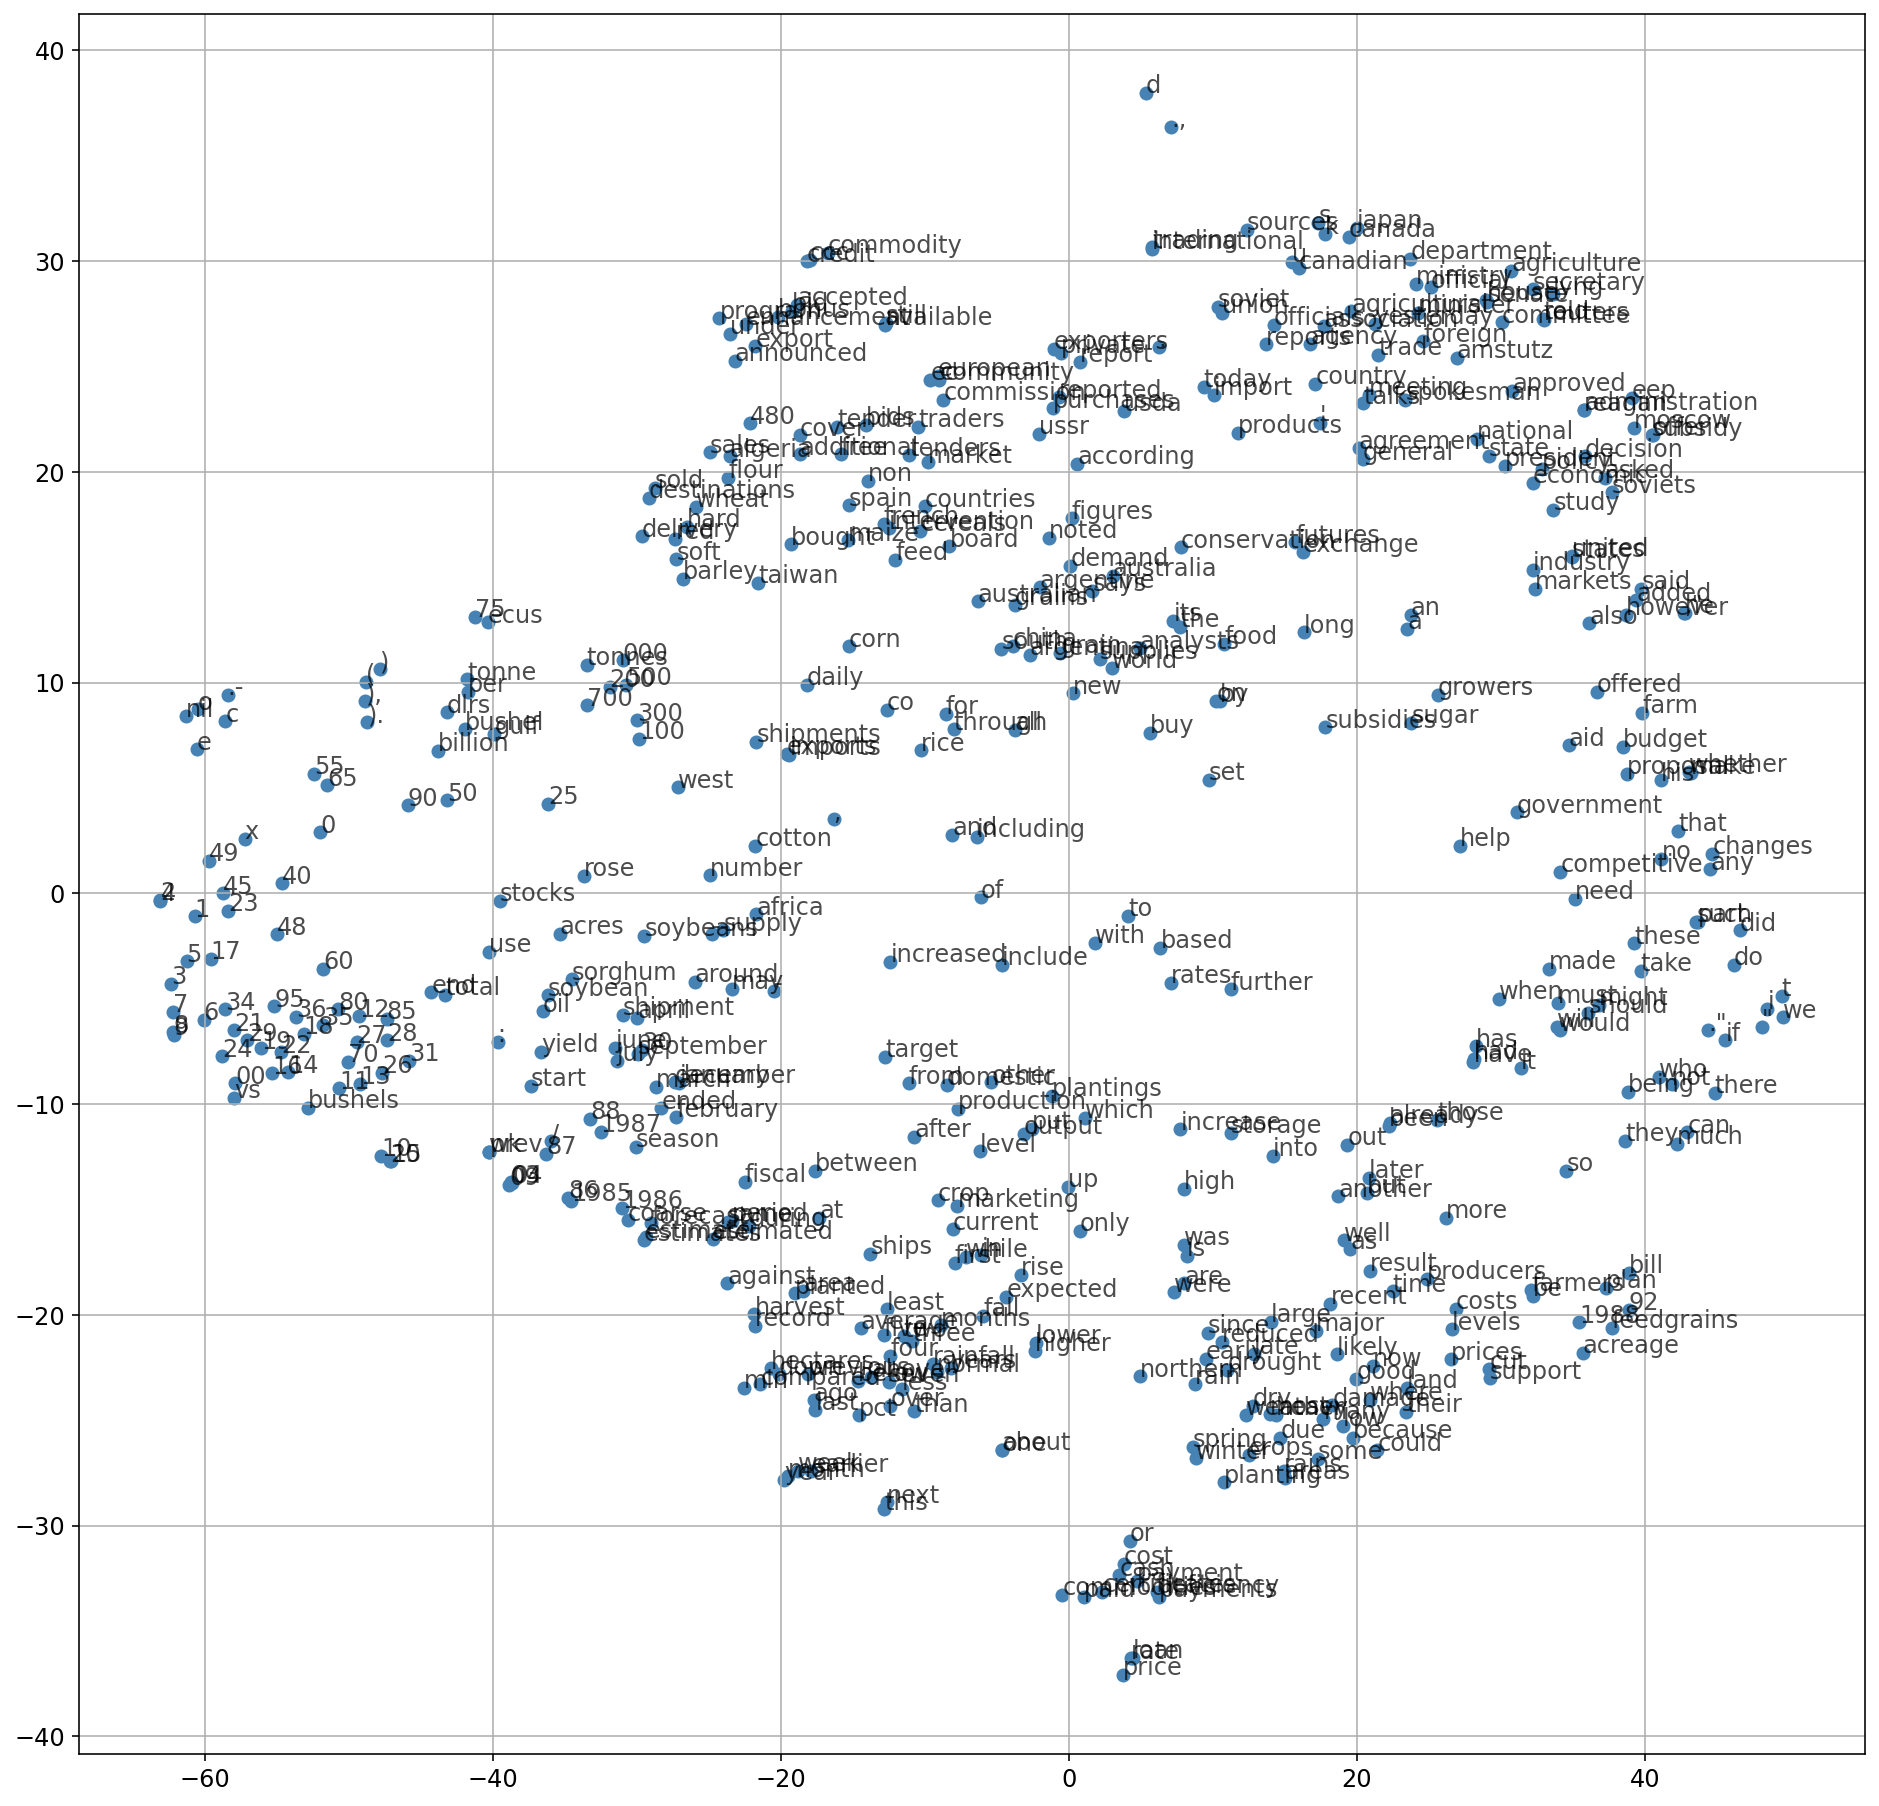

In [ ]:
# Dibujar solo 500 embeddings

fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate(words[:500]):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
      
plt.grid()

Con una mera inspección visual a través de t-SNE, podemos comprobar cómo el diccionario de word embeddings no tiene una estructura interna coherente. Para estudiar esta coherencia interna, alternativamente podemos buscar los vecinos más cercanos a una palabra dada para comprobar si son semanticamente coherentes. 

Es usual medir la distancia entre vectores utilizando la **distancia coseno** y se calcula como sigue:

$$d_\text{cos}(\mathbf{v}_1,\mathbf{v}_2) = 1- \frac{\mathbf{v}_1^T~\mathbf{v}_2}{||\mathbf{v}_1||_2 ||\mathbf{v}_2||}=1-\cos(\Phi)$$

donde $||\mathbf{v}||_2 = \sqrt{\mathbf v^\top \mathbf v}$ y $\Phi$ es el ángulo que forman ambos vectores. A $\cos(\Phi)$ se le denomina **similitud coseno** (cosine similarity) entre ambos vectores.


<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/NLP/NLP1.png" width="100%"> 

Y como podemos ver en la siguiente figura, sus resultados no tienen nada que ver con la distancia euclídea (no dependen de la longitud de los vectores)

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/NLP/NLP2.png" width="60%"> 






Gensim nos proporciona una función para encontar los vecinos más cercanos a una palabra dada usando la **similitud coseno** como métrica para la similitud:

In [ ]:
model.wv.most_similar('cotton')

[('germany', 0.9201756715774536),
 ('grown', 0.9104759097099304),
 ('sorghum', 0.9009690284729004),
 ('short', 0.8984436392784119),
 ('included', 0.8963244557380676),
 ('various', 0.8943551182746887),
 ('netherlands', 0.8942928314208984),
 ('running', 0.8907755613327026),
 ('continental', 0.8845623731613159),
 ('issued', 0.8839950561523438)]

In [ ]:
model.wv.most_similar('harvest')

[('record', 0.9067995548248291),
 ('fall', 0.9019722938537598),
 ('paddy', 0.8927426338195801),
 ('february', 0.8795933127403259),
 ('volume', 0.8748949766159058),
 ('first', 0.8512652516365051),
 ('quarter', 0.8504384160041809),
 ('period', 0.8496869206428528),
 ('after', 0.8460102081298828),
 ('decline', 0.8426181077957153)]

Podemos comprobar que efectivamente se está calculando la similitud coseno ...

In [ ]:
dc = model.wv['cotton']@model.wv['increases']

dc /= np.linalg.norm(model.wv['cotton'])

dc /= np.linalg.norm(model.wv['increases'])

print(dc)

print(model.wv.similarity('cotton','increases'))

0.728078
0.728078


Ciertamente, necesitamos entrenar en una base de datos mucho mayor para obtener una estructura de embeddings coherentes. En cualquier caso, podemos salvar el modelo Word2Vec entrenado para utilizarlo o continuar con su entrenamiento en el futuro ...

In [ ]:
model.save("word2vec_cereal_news.model")

Para cargar el modelo utilizaremos `Word2Vec.load()`. Podemos re-entrenar el modelo con más texto y nuevas palabras en el vocabulario:

In [ ]:
print(f"El vocabulario actual contiene {len(model.wv)} palabras")

El vocabulario actual contiene 1407 palabras


In [ ]:
more_sentences = reuters.sents(reuters.fileids(['cotton'])) 

model = Word2Vec.load("word2vec_cereal_news.model")

model.build_vocab(more_sentences, update=True)
model.train(more_sentences, total_examples=model.corpus_count, epochs=model.epochs)

print(f"El nuevo vocabulario contiene {len(model.wv)} palabras")

model.save("word2vec_cereal_cotton_news.model")


El nuevo vocabulario contiene 1476 palabras


> **Ejercicio**: Repita el entrenamiento del word2vec aumentando la dimensionalidad. ¿Mejoran los resultados a la vista de t-SNE?

In [ ]:
model2 = Word2Vec(reuters_sent_norm, sg=1, vector_size = 300, window=5, min_count=10,epochs=50)
print(model2)

Word2Vec(vocab=1407, vector_size=300, alpha=0.025)


In [ ]:
embeddings = model2.wv.vectors 

In [ ]:
embed_tsne = tsne.fit_transform(embeddings)

/Users/olmos/opt/anaconda3/envs/gensim4/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/olmos/opt/anaconda3/envs/gensim4/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


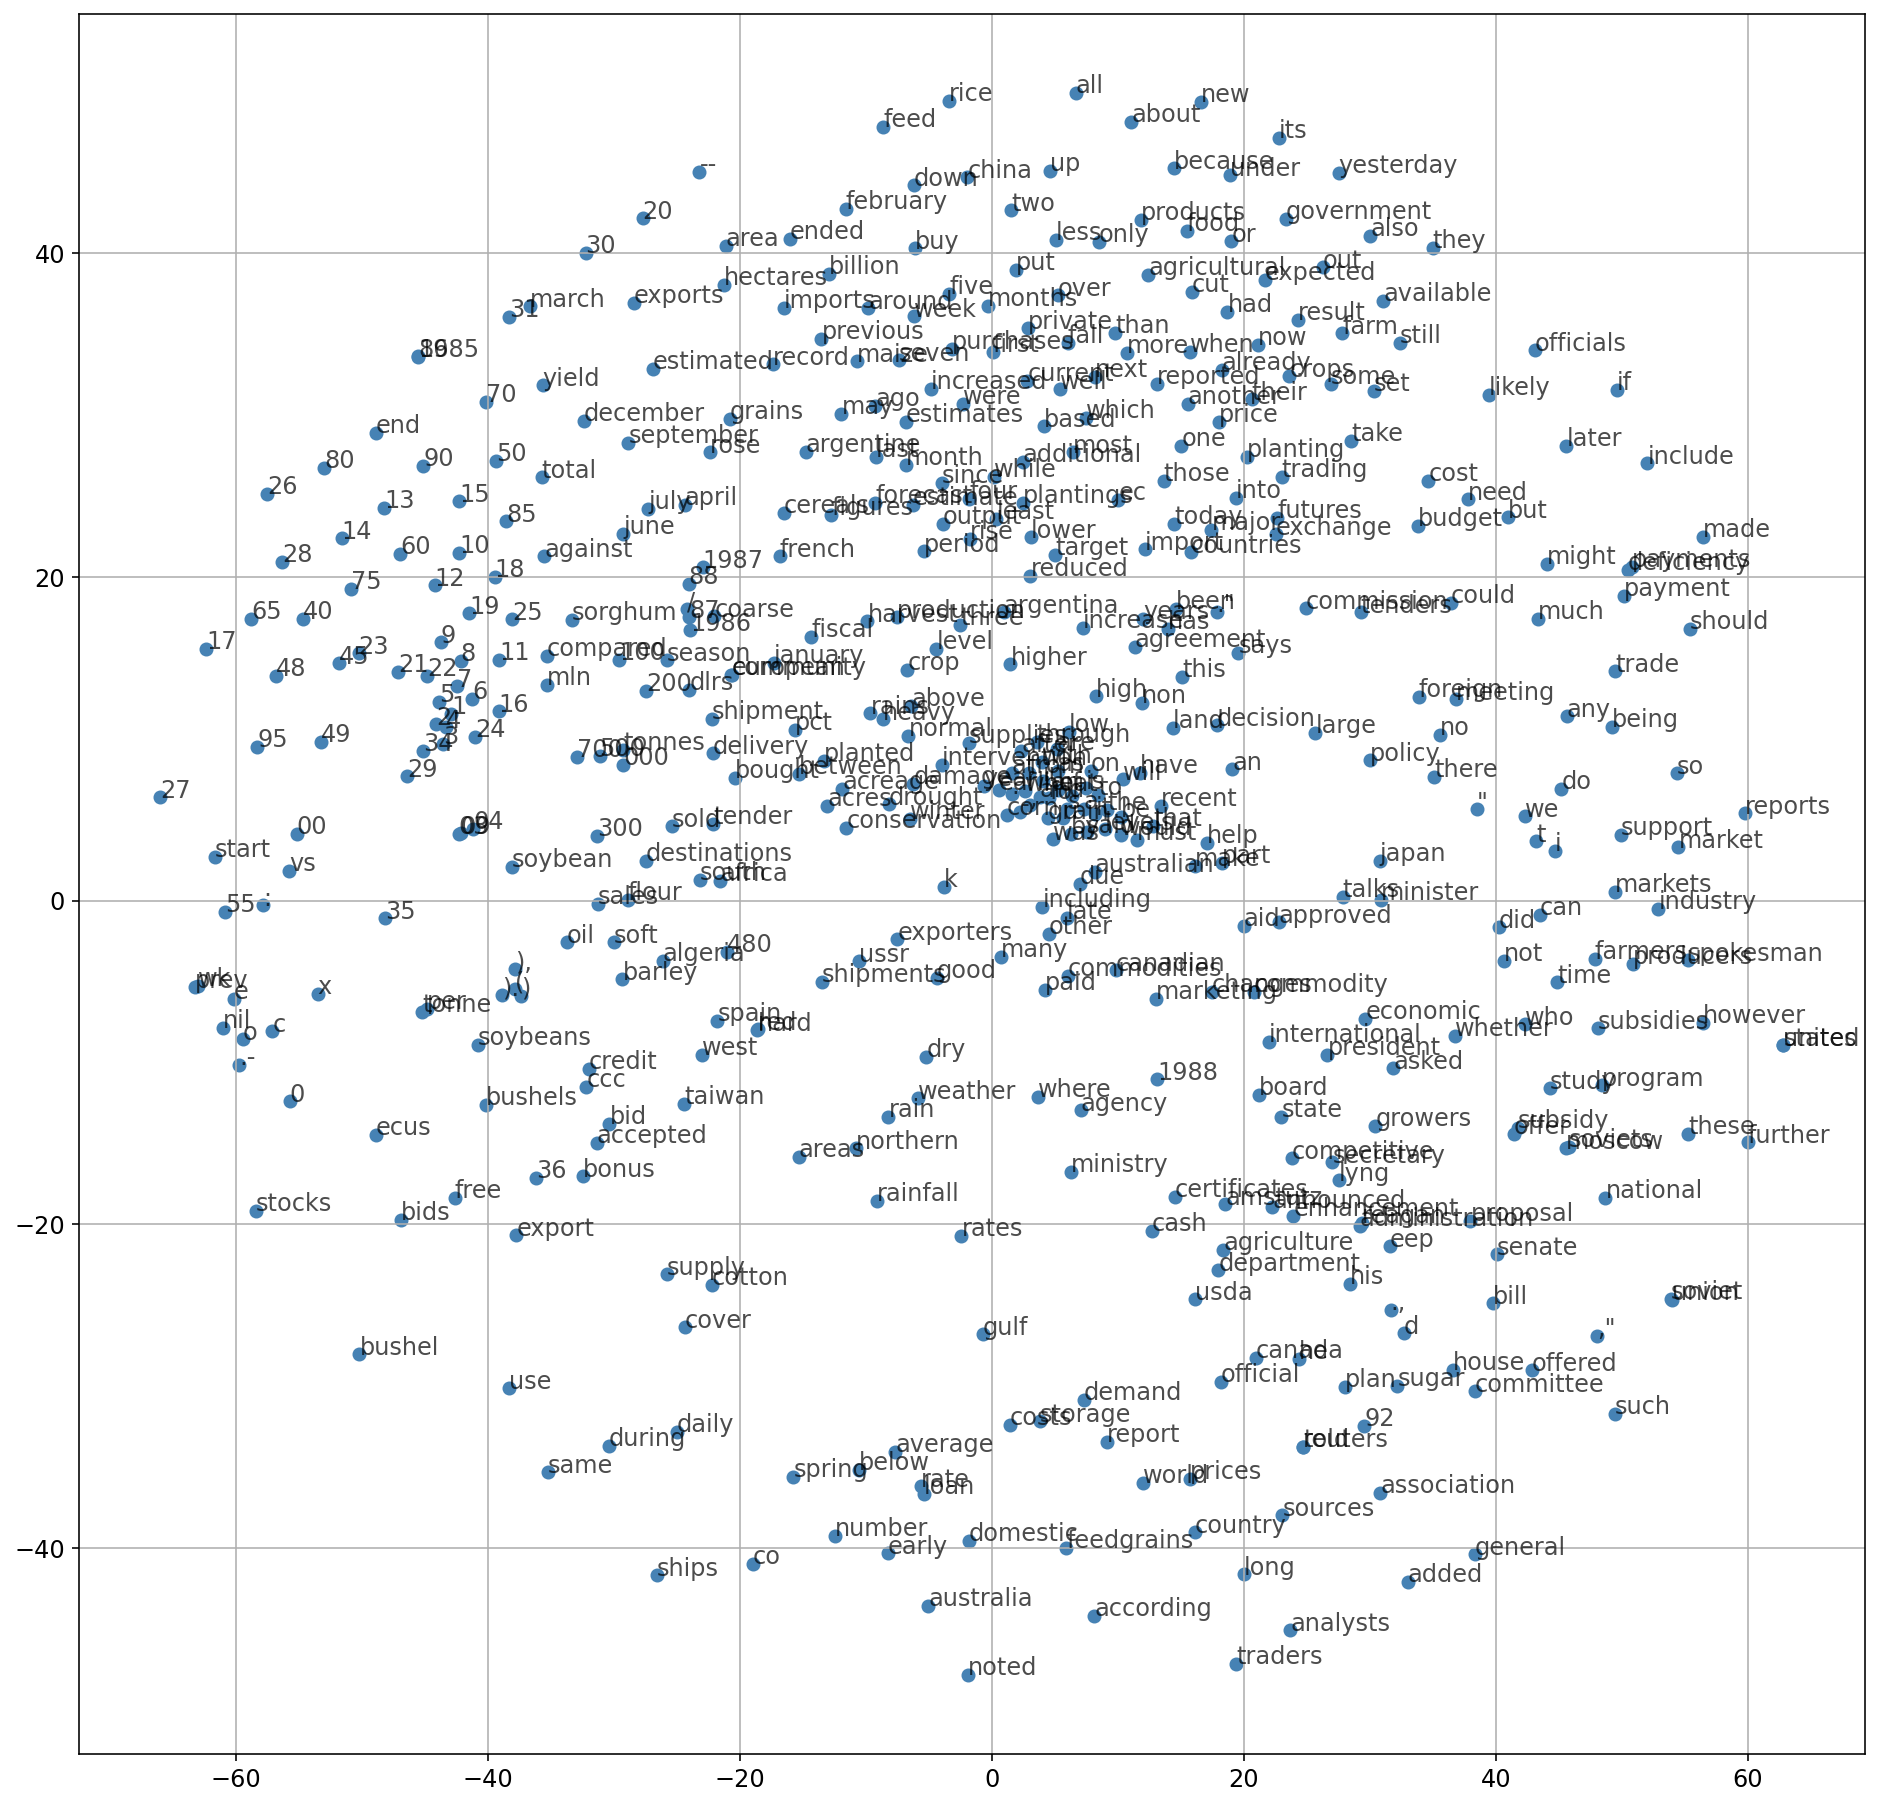

In [ ]:
# Dibujar solo 500 embeddings

fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(model.wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
      
plt.grid()

In [ ]:
model2.wv.most_similar('cotton')

[('bales', 0.37952595949172974),
 ('cake', 0.35068511962890625),
 ('cont', 0.32387128472328186),
 ('meal', 0.3136337697505951),
 ('allowed', 0.3064659833908081),
 ('sorghum', 0.3052237033843994),
 ('oct', 0.29763132333755493),
 ('pakistan', 0.2972831130027771),
 ('running', 0.29459401965141296),
 ('g', 0.2923375070095062)]

In [ ]:
model2.wv.most_similar('harvest')

[('record', 0.3558875322341919),
 ('advanced', 0.34163612127304077),
 ('producing', 0.33037662506103516),
 ('sown', 0.3290804624557495),
 ('sunflower', 0.328227162361145),
 ('forecasts', 0.32174184918403625),
 ('forecast', 0.3190363645553589),
 ('raised', 0.31820258498191833),
 ('crop', 0.3170577883720398),
 ('harvesting', 0.30999746918678284)]

## 2.6 Inclusión de bi-gramas y tri-gramas en el vocabulario

Las expresiones de varias palabras que aparecen conjuntamente con mucha frecuencia (e.g. bigramas / trigramas) tienen un significado diferente al de las palabras que aparecen de forma singular. Por ejemplo, las palabras "nueva" y "York" expresadas de forma singular son inherentemente diferentes a la expresión "Nueva York". Asímismo, tendríamos el ejemplo de "New York Times" frente a "New York" y "times".

La clase [`Phraser`](https://radimrehurek.com/gensim/models/phrases.html) de Gensim nos permite detectar co-ocurrencias frecuentes y aplicar una transformación para crear tokens únicos del tipo ‘New York’ -> ‘New_York’. Preprocesar el texto para crear este tipo de tokens formados a partir de bigramas puede mejorar nuestro conjunto de word embeddings, de forma que entrenaremos un único vector para ‘New_York’, además de dos embeddings separados.

A continuación mostramos el uso de esta clase en el dataset que hemos usado para entrenar Wor2Vec en la sección anterior ...

In [ ]:
import gensim.models.phrases as ph

'''Connector words: Set of words that may be included within a phrase, 
without affecting its scoring. No phrase can start nor end with a connector word; 
a phrase may contain any number of connector words in the middle.'''
connector_words = ph.ENGLISH_CONNECTOR_WORDS

print(connector_words)

# Detectamos co-ocurrencias frecuentes
phrase_model = ph.Phrases(reuters_sent_norm,connector_words=connector_words)

frozenset({'and', 'to', 'or', 'a', 'an', 'on', 'for', 'by', 'of', 'with', 'without', 'from', 'the', 'in', 'at'})


Utilizaremos `phrase_model` para codificar cada uno de los documentos de nuestro corpus incluyendo las co-ocurrencias detectadas:

In [ ]:
reuters_sent_phrases = list(phrase_model[reuters_sent_norm])

Imprimamos dos oraciones a modo de ejemplo ...

In [ ]:
print(' '.join(reuters_sent_phrases[22]))
print('\n')
print(' '.join(reuters_sent_phrases[45]))

u . s . agriculture_secretary richard_lyng , who is due to visit japan for talks between april 16 - 27 , has said he will ask japan to offer a share of its rice market to u . s .


rains in the middle of last_week reached an average of 27 millimetres in parts of buenos_aires province , 83 mm in cordoba , 41 in santa_fe , 50 in entre rios and misiones , 95 in corrientes , eight in chaco and 35 in formosa .


Utlizando `reuters_sent_phrases` ahora podríamos re-entrenar Word2Vec utilizando las co-ocurrencias detectadas.

## 2.7 Modelos wor2vec pre-entrenados en gensim

Gensim incluye funciones para explotar un conjunto de [*embeddings* preentrenados](https://github.com/RaRe-Technologies/gensim-data). Pueden ser un conjunto de *embeddings* que hemos entrenado nosotros, o puede utilizar directamente un modelo preentrenado con un gran corpus de datos. Muchos de ellos están disponibles en abierto para su uso.



In [ ]:
import gensim.downloader

# Show all available models in gensim-data

print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Vamos a cargar `word2vec-google-news-300`, que contiene *embeddings* de dimensión 300 para un vocabulario de 3 millones de palabras. La siguiente celda de código carga este modelo (tarda un poco...)

In [ ]:
w2vec_google_news = gensim.downloader.load('word2vec-google-news-300')

In [ ]:
print(f"El tamaño del diccionario es {w2vec_google_news.vectors.shape[0]}. Cada embedding tiene una dimensión de {w2vec_google_news.vectors.shape[1]}")

El tamaño del diccionario es 3000000. Cada embedding tiene una dimensión de 300


Vamos a repetir las dos pruebas que hicimos antes para comprobar la coherencia semántica del diccionario de embeddings ...

In [ ]:
# tsne de los 1000 primeros vectores

embed_tsne = tsne.fit_transform(w2vec_google_news.vectors[:1000,:])

/Users/olmos/opt/anaconda3/envs/gensim4/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/olmos/opt/anaconda3/envs/gensim4/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


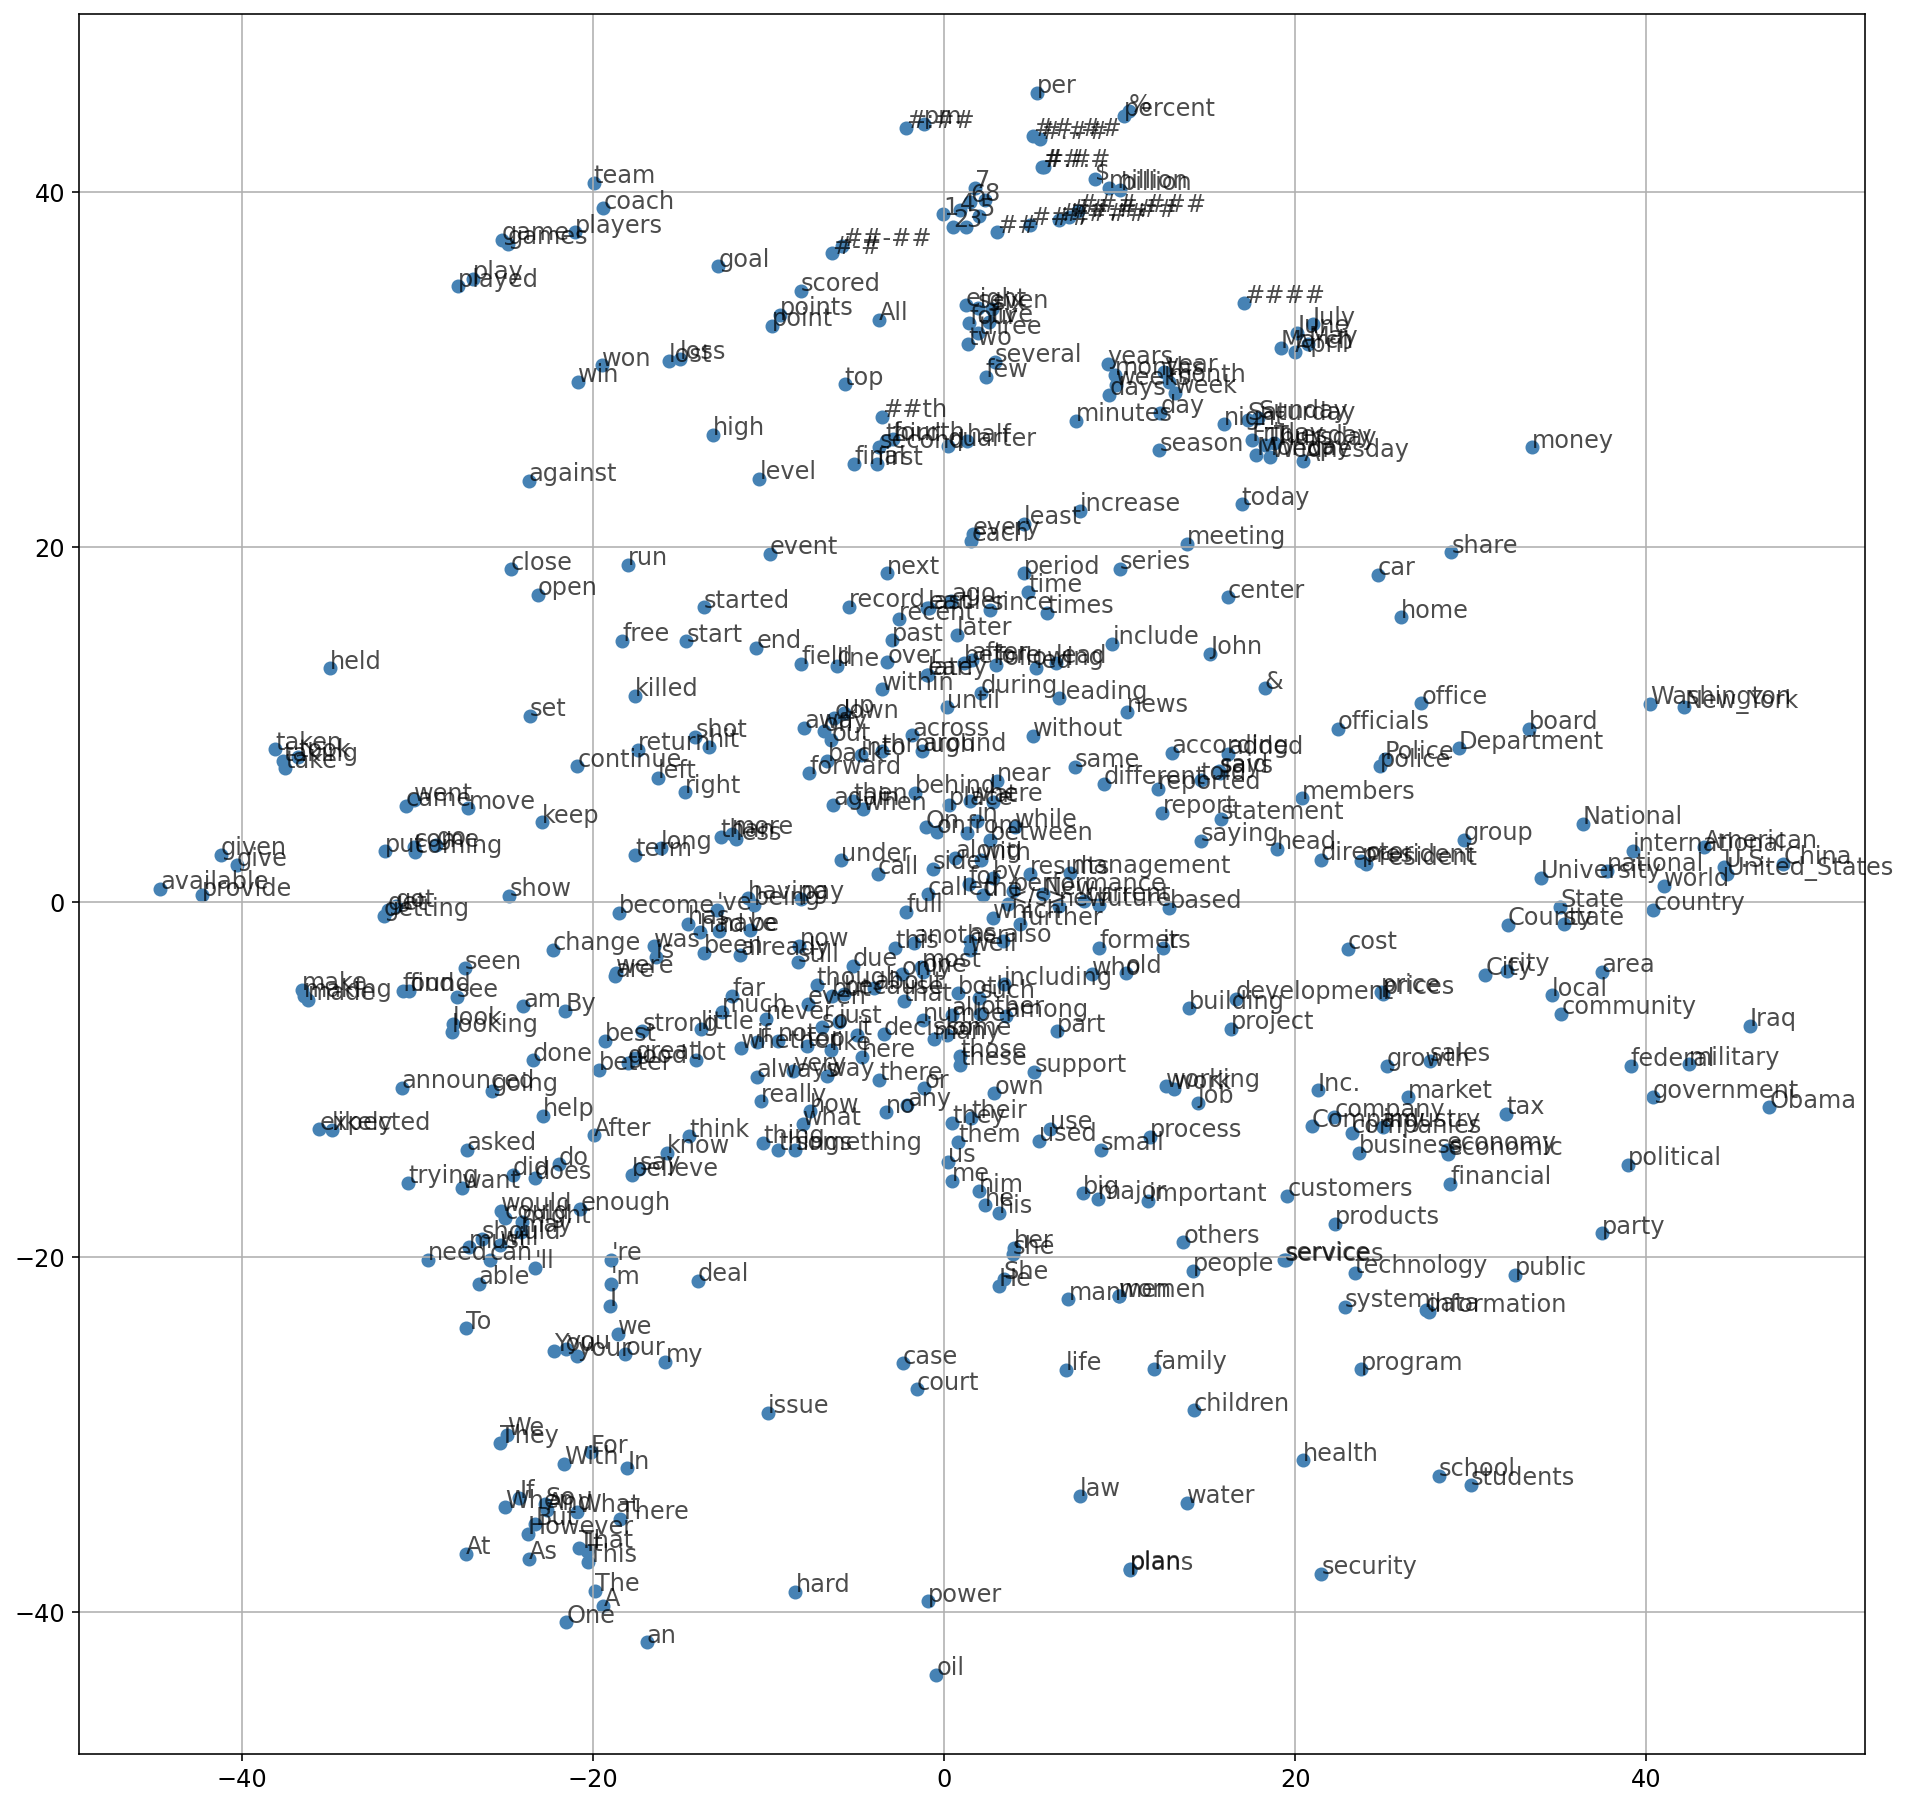

In [ ]:
# Dibujar solo 500 embeddings

fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(w2vec_google_news.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
    
    
plt.grid()

Como podemos comprobar, la coherencia del modelo ha mejorado notablemente. Vamos a calcular los vecinos más cercanos de algunas palabras ...

In [ ]:
w2vec_google_news.most_similar('cotton')

[('Cotton', 0.6608946919441223),
 ('cottons', 0.6323673725128174),
 ('cotton_lint', 0.625328540802002),
 ('cotton_yarns', 0.6085416674613953),
 ('cotton_fabrics', 0.605631411075592),
 ('Upland_cotton', 0.5978441834449768),
 ('cotton_growers', 0.5913089513778687),
 ('organic_cotton', 0.5894070267677307),
 ('jute', 0.5883727669715881),
 ('Pima_cotton', 0.5870891213417053)]

In [ ]:
w2vec_google_news.most_similar('harvest')

[('harvests', 0.787251353263855),
 ('harvesting', 0.7456287145614624),
 ('harvested', 0.6959839463233948),
 ('Harvesting', 0.6250583529472351),
 ('wheat_harvest', 0.6063814759254456),
 ('crop', 0.5988492965698242),
 ('bountiful_harvest', 0.5810245871543884),
 ('Corn_silage', 0.578718364238739),
 ('grape_harvest', 0.5738621950149536),
 ('berry_crop', 0.5615768432617188)]

# 3. Validación intrínseca de word embeddings

La visualización t-SNE y el cálculo de vecinos más cercanos de algunas palabras nos puede dar una primera idea sobre la coherencia de un diccionario de word embeddings. Sin embargo, a la hora de **comparar word embeddings entrenados en corpus distintos o distintos tipos de embeddings para un mismo corpus**, necesitaremos una batería de experimentos más profunda. 

Debemos tener en cuenta que el entrenamiento de word embeddings es un problema de aprendizaje no supervisado y por tanto no hay una métrica única. Exsisten distintas aproximaciones para la evaluación/comparación de word embeddings. Este [artículo](https://arxiv.org/pdf/1801.09536.pdf) trata el tema de forma profunda. Podemos diferenciar dos tipos técnicas de validación:

- **Métodos extrínsecos** se basan en la capacidad de los embeddings para usarse como vectores de características en aprendizaje automático supervisado (e.g. clasificación de documentos, NER, POS tagging, NP chuking, ...). Dada una misma base de datos, podemos comparar distintos esquemas de word embeddings y quedarnos con aquel que optimice el rendimiento del modelo supervisado. **Esta vía la exploraremos en futuras sesiones/proyectos**.
$$$$
- **Métodos intrínsecos** son experimentos en los que comparamos las relaciones entre palabras usando word embeddings y aquellas que daría una persona. Se trabaja con bases de datos creadas manualmente en las que se recojen distintos tipos de relaciones entre palabras. Escogeremos aquel diccionario de word embeddings que se aproxime más a los resultados recogidos en dichas bases de datos.

A continuación vamos a explorar dos métodos intrínsecos para caracterizar el diccionario de embeddings `word2vec-google-news-300`. Las bases de datos que vamos a usar han sido descargadas de [este repositorio](https://github.com/vecto-ai/word-benchmarks).



## 3.1 Word analogy

Este método de evaluación, conocido también como razonamiento analógico, regularidades lingüísticas o coherencia semántica de palabras, se basa en la idea de que **operaciones aritméticas en un espacio de word embeddings pueden ser predichas por una persona**: dado un conjunto de tres palabras $\bf a$=Francia, $\bf a'$=Paris, $\bf b$=Madrid, la tarea consiste en identificar una palabra con vector $\bf b'$ tal que la relación entre $\bf b$=Madrid y $\bf b'$ sea la misma que entre $\bf a$ y $\bf a'$. En nuestro ejemplo, $\bf b'$= Spain, puesto que la relación $\bf a:a'$ es *capital:país*. 

En este [artículo pionero](https://arxiv.org/pdf/1310.4546.pdf) los autores demostraron que el problema anterior puede aproximarse usando un espacio de word embeddings de forma muy sencilla. Dados los vectores $\bf a,a'$ y $\bf b$ aproximamos $\bf b'$ como aquella palabra que minimiza la distancia coseno con el vector $\bf (a-a'+b)$:

$$ \mathbf{b}' \approx \min_{\mathbf{w}\in \text{Word Embeddings}, \mathbf{w}\notin \{a,a',b\}} \text{cos_dist}\left(\mathbf{w},\mathbf{a-a'+b}\right)$$

Posteriormente, en este otro [artículo](https://www.aclweb.org/anthology/W14-1618.pdf) se modifica la solución anterior introduciendo la distancia `3COSMUL` que proprciona un mejor balance entre los distintos aspectos de la analogía entre palabras:

$$ \mathbf{b}' \approx \min_{\mathbf{w}\in \text{Word Embeddings}, \mathbf{w}\notin \{a,a',b\}} \text{3COSMUL}\left(\mathbf{w},\mathbf{a},\mathbf{a'},\mathbf{b}\right)$$

donde

$$\text{3COSMUL}\left(\mathbf{w},\mathbf{a},\mathbf{a'},\mathbf{b}\right) = \frac{\cos(\mathbf{w},\mathbf{b})\cos(\mathbf{w},\mathbf{a'})}{\cos(\mathbf{w},\mathbf{a})+\epsilon}$$

y $\epsilon$ es una constante pequeña para evitar la división por cero.

Gensim proporciona las funciones `most_similar()` y `most_similar_cosmul()` para resolver el problema de acuerdo a las dos métricas anteriores:

In [ ]:
a_ = 'Paris'
a = 'France' 
b = 'Madrid'

# distancia coseno con a-a'+b
w2vec_google_news.most_similar(positive=[a, b], negative=[a_], topn=10)

[('Spain', 0.7776164412498474),
 ('Portugal', 0.6343988180160522),
 ('Spaniards', 0.6030073165893555),
 ('Real_Madrid', 0.6006272435188293),
 ('Spains', 0.5953583121299744),
 ('Barcelona', 0.5761324167251587),
 ('Zapatero', 0.5729910135269165),
 ('Sevilla', 0.5728215575218201),
 ('Catalan', 0.5721344351768494),
 ('Catalonia', 0.570748507976532)]

In [ ]:
# 3COSMUL entre a,a' y b

w2vec_google_news.most_similar_cosmul(positive=[a, b], negative=[a_], topn=10)

[('Spain', 0.9859195947647095),
 ('Portugal', 0.9004181027412415),
 ('Spaniards', 0.8752938508987427),
 ('Real_Madrid', 0.874714732170105),
 ('Spains', 0.866932213306427),
 ('Sevilla', 0.8520594239234924),
 ('Zapatero', 0.8513649106025696),
 ('Argentina', 0.8502999544143677),
 ('la_Furia_Roja', 0.850062906742096),
 ('Catalonia', 0.8476372361183167)]

Con esta idea, vamos a comprobar el porcentaje de aciertos en la base de datos [Google Analogy](https://aclweb.org/aclwiki/Analogy_(State_of_the_art)), que contiene 19544 duplas de cuatro palabras ($\bf a,a',b,b'$).

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/vecto-ai/word-benchmarks/master/word-analogy/monolingual/en/google-analogies.csv",
                 names=['ID','type','Word a_','Word a','Word b','Word b_'],header=0)
df.set_index('ID',inplace=True)

df

type Word a_  Word a   Word b      Word b_
ID                                                                   
0      capital-common-countries  Athens  Greece  Baghdad         Iraq
1      capital-common-countries  Athens  Greece  Bangkok     Thailand
2      capital-common-countries  Athens  Greece  Beijing        China
3      capital-common-countries  Athens  Greece   Berlin      Germany
4      capital-common-countries  Athens  Greece     Bern  Switzerland
...                         ...     ...     ...      ...          ...
19539        gram9-plural-verbs   write  writes     talk        talks
19540        gram9-plural-verbs   write  writes    think       thinks
19541        gram9-plural-verbs   write  writes   vanish     vanishes
19542        gram9-plural-verbs   write  writes     walk        walks
19543        gram9-plural-verbs   write  writes     work        works

[19544 rows x 5 columns]

Como podemos ver hay varias categorías de relaciones ...

In [ ]:
print(f"La lista de {len(df['type'].unique())} categorías es\n {df['type'].unique()}")

La lista de 14 categorías es
 ['capital-common-countries' 'capital-world' 'currency' 'city-in-state'
 'family' 'gram1-adjective-to-adverb' 'gram2-opposite' 'gram3-comparative'
 'gram4-superlative' 'gram5-present-participle'
 'gram6-nationality-adjective' 'gram7-past-tense' 'gram8-plural'
 'gram9-plural-verbs']


Vamos a predecir la palabra $\bf b\_$ usando ambos métodos ...

In [ ]:
def analogy_dist_cos(model,a_,a,b):
    most_similar = '******'
    # Check three words belong to diccionary
    if (a in model.key_to_index.keys() and a_ in model.key_to_index.keys() and b in model.key_to_index.keys()):
        most_similar = model.most_similar(positive=[a, b], negative=[a_], topn=1)[0][0]
    
    return most_similar

def analogy_3cosmul(model,a_,a,b):
    most_similar = '******'
    # Check three words belong to diccionary
    if (a in model.key_to_index.keys() and a_ in model.key_to_index.keys() and b in model.key_to_index.keys()):
        most_similar = model.most_similar_cosmul(positive=[a, b], negative=[a_], topn=1)[0][0]
        
    return most_similar

def es_correcto(c,d):
    return c==d

Vamos a crear una nueva columna con la predicción de ambos métodos ... (para acelerar vamos a considerar sólo 
100 registros aleatorios)

In [ ]:
df_red = df.sample(n=100).copy()

In [ ]:
df_red['distancia coseno'] = df_red[['Word a_','Word a','Word b']].apply(lambda row: analogy_dist_cos(w2vec_google_news,*row),axis=1)

In [ ]:
df_red['correct_dist_cos'] = df_red[['Word b_','distancia coseno']].apply(lambda row: es_correcto(*row),axis=1)

In [ ]:
df_red['3cosmul'] = df_red[['Word a_','Word a','Word b']].apply(lambda row: analogy_3cosmul(w2vec_google_news,*row),axis=1)

In [ ]:
df_red['correct_3cosmul'] = df_red[['Word b_','3cosmul']].apply(lambda row: es_correcto(*row),axis=1)

In [ ]:
df_red.head(20)

type     Word a_      Word a      Word b  \
ID                                                                    
1032              capital-world      Bamako        Mali  Copenhagen   
6441              city-in-state   Nashville   Tennessee   Arlington   
8007              city-in-state  Shreveport   Louisiana   Worcester   
13385  gram5-present-participle    generate  generating    increase   
1589              capital-world   Bujumbura     Burundi        Lima   
19199        gram9-plural-verbs     shuffle    shuffles       speak   
18924        gram9-plural-verbs   implement  implements        walk   
7468              city-in-state   Henderson      Nevada     Detroit   
13581  gram5-present-participle      listen   listening         say   
16460          gram7-past-tense      moving       moved    striking   
8605                     family     husband        wife        king   
19430        gram9-plural-verbs      vanish    vanishes       write   
15857          gram7-past-tense  decreasing   decreased     walking   
10774         gram3-comparative      bright    brighter       tough   
1733              capital-world    Chisinau     Moldova     Kampala   
13923  gram5-present-participle     shuffle   shuffling         run   
6679              city-in-state        Mesa     Arizona       Omaha   
214    capital-common-countries      Havana        Cuba     Beijing   
12513         gram4-superlative       lucky    luckiest        warm   
4405              capital-world     Tbilisi     Georgia     Bishkek   

             Word b_    distancia coseno  correct_dist_cos        3cosmul  \
ID                                                                          
1032         Denmark  Copenhagen_Denmark             False        Denmark   
6441           Texas               Texas              True          Texas   
8007   Massachusetts       Massachusetts              True  Massachusetts   
13385     increasing          increasing              True     increasing   
1589            Peru                Peru              True           Peru   
19199         speaks              speaks              True         speaks   
18924          walks               walks              True          walks   
7468        Michigan            Michigan              True       Michigan   
13581         saying             believe             False        believe   
16460         struck              struck              True         struck   
8605           queen               kings             False          kings   
19430         writes             writing             False        writing   
15857         walked              walked              True         walked   
10774        tougher             tougher              True        tougher   
1733          Uganda              Uganda              True         Uganda   
13923        running             running              True        running   
6679        Nebraska            Nebraska              True       Nebraska   
214            China               China              True          China   
12513        warmest             warmest              True        warmest   
4405      Kyrgyzstan          Kyrgyzstan              True     Kyrgyzstan   

       correct_3cosmul  
ID                      
1032              True  
6441              True  
8007              True  
13385             True  
1589              True  
19199             True  
18924             True  
7468              True  
13581            False  
16460             True  
8605             False  
19430            False  
15857             True  
10774             True  
1733              True  
13923             True  
6679              True  
214               True  
12513             True  
4405              True

In [ ]:
print(f"El % de aciertos de la distancia coseno es {df_red['correct_dist_cos'].sum()/df_red.shape[0]}")
print(f"El % de aciertos de la distancia 3cosmul es {df_red['correct_3cosmul'].sum()/df_red.shape[0]}")

El % de aciertos de la distancia coseno es 0.7
El % de aciertos de la distancia 3cosmul es 0.71


## 3.2 Detección de palabras fuera de contexto (word outliers)

La tarea consiste en identificar palabras semáticamente anómalas en un grupo de palabras semánticamente coherentes. Por ejemplo, en el conjunto ${orange, banana, lemon, book, orange}$ la palabra $book$ es claramente un outlier. Las distancias relativas entre word embeddings debería ser una característica suficiente para identificar este outlier.

La función `doesnt_match([list of words])` de Gensim devuelve la palabra cuyo embedding está más lejos de la media de los embeddings de todas las palabras.

In [ ]:
print(w2vec_google_news.doesnt_match(['orange','banana','lemon','book']))


book


A continuación cargamos la base de datos `8-8-8.csv`, en el que tenemos 8 grupos de 8 palabras cada uno y 8 outliers asociados por grupo. 

In [ ]:
df_out = pd.read_csv("8-8-8v2.csv",names=['Word '+str(d) for d in range(8)]+['Outlier'],header=1)

In [ ]:
df_out

Word 0    Word 1     Word 2  Word 3      Word 4       Word 5  \
0           Apple   Foxconn     Amazon      HP   Microsoft          IBM   
1           Apple   Foxconn     Amazon      HP   Microsoft          IBM   
2           Apple   Foxconn     Amazon      HP   Microsoft          IBM   
3           Apple   Foxconn     Amazon      HP   Microsoft          IBM   
4           Apple   Foxconn     Amazon      HP   Microsoft          IBM   
5           Apple   Foxconn     Amazon      HP   Microsoft          IBM   
6           Apple   Foxconn     Amazon      HP   Microsoft          IBM   
7   Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
8   Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
9   Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
10  Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
11  Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
12  Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
13  Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
14  Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
15          tiger      lion     cougar  jaguar     leopard      cheetah   
16          tiger      lion     cougar  jaguar     leopard      cheetah   
17          tiger      lion     cougar  jaguar     leopard      cheetah   
18          tiger      lion     cougar  jaguar     leopard      cheetah   
19          tiger      lion     cougar  jaguar     leopard      cheetah   
20          tiger      lion     cougar  jaguar     leopard      cheetah   
21          tiger      lion     cougar  jaguar     leopard      cheetah   
22          tiger      lion     cougar  jaguar     leopard      cheetah   
23         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
24         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
25         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
26         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
27         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
28         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
29         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
30         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
31        January     March        May    July   September     November   
32        January     March        May    July   September     November   
33        January     March        May    July   September     November   
34        January     March        May    July   September     November   
35        January     March        May    July   September     November   
36        January     March        May    July   September     November   
37        January     March        May    July   September     November   
38        January     March        May    July   September     November   
39        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
40        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
41        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
42        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
43        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
44        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
45        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
46        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
47          Peter    Andrew      James    John   Thaddaeus  Bartholomew   
48          Peter    Andrew      James    John   Thaddaeus  Bartholomew   
49          Peter    Andrew      James    John   Thaddaeus  Bartholomew   
50          Peter    Andrew      James    John   Thaddaeus  Bartholomew   
51          Peter    Andrew      James    John   Thaddaeus  Bartholomew   
52          Peter    Andrew      Jam

Vamos a añadir la predicción del outlier al dataframe y contar aciertos ...

In [ ]:
df_out['Predicted Outlier'] = df_out.apply(lambda row: w2vec_google_news.doesnt_match(row),axis=1)

df_out['Correct'] = df_out[['Outlier','Predicted Outlier']].apply(lambda row: es_correcto(*row),axis=1)

In [ ]:
df_out

Word 0    Word 1     Word 2  Word 3      Word 4       Word 5  \
0           Apple   Foxconn     Amazon      HP   Microsoft          IBM   
1           Apple   Foxconn     Amazon      HP   Microsoft          IBM   
2           Apple   Foxconn     Amazon      HP   Microsoft          IBM   
3           Apple   Foxconn     Amazon      HP   Microsoft          IBM   
4           Apple   Foxconn     Amazon      HP   Microsoft          IBM   
5           Apple   Foxconn     Amazon      HP   Microsoft          IBM   
6           Apple   Foxconn     Amazon      HP   Microsoft          IBM   
7   Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
8   Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
9   Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
10  Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
11  Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
12  Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
13  Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
14  Mercedes_Benz       BMW       Audi    Opel  Volkswagen      Porsche   
15          tiger      lion     cougar  jaguar     leopard      cheetah   
16          tiger      lion     cougar  jaguar     leopard      cheetah   
17          tiger      lion     cougar  jaguar     leopard      cheetah   
18          tiger      lion     cougar  jaguar     leopard      cheetah   
19          tiger      lion     cougar  jaguar     leopard      cheetah   
20          tiger      lion     cougar  jaguar     leopard      cheetah   
21          tiger      lion     cougar  jaguar     leopard      cheetah   
22          tiger      lion     cougar  jaguar     leopard      cheetah   
23         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
24         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
25         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
26         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
27         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
28         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
29         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
30         Brazil  Colombia  Argentina    Peru   Venezuela        Chile   
31        January     March        May    July   September     November   
32        January     March        May    July   September     November   
33        January     March        May    July   September     November   
34        January     March        May    July   September     November   
35        January     March        May    July   September     November   
36        January     March        May    July   September     November   
37        January     March        May    July   September     November   
38        January     March        May    July   September     November   
39        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
40        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
41        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
42        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
43        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
44        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
45        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
46        Mercury     Venus      Earth    Mars     Jupiter       Saturn   
47          Peter    Andrew      James    John   Thaddaeus  Bartholomew   
48          Peter    Andrew      James    John   Thaddaeus  Bartholomew   
49          Peter    Andrew      James    John   Thaddaeus  Bartholomew   
50          Peter    Andrew      James    John   Thaddaeus  Bartholomew   
51          Peter    Andrew      James    John   Thaddaeus  Bartholomew   
52          Peter    Andrew      Jam

In [ ]:
print(f"El % de aciertos en la detección del outlier es {df_out['Correct'].sum()/df_out.shape[0]}")

El % de aciertos en la detección del outlier es 0.6666666666666666


In [ ]:
# Liberemos memoria ...
del(w2vec_google_news)
gc.collect()

25

## 3.3 Word embeddings entrenados en dominios específicos

Existen numerosos diccionarios de embeddings entrenados en dominios específicos a nuestra disposición:

* [BioWordVec & BioSentVec: pre-trained embeddings for biomedical words and sentences](https://github.com/ncbi-nlp/BioSentVec)

* [Law2Vec: Legal Word Embeddings](https://archive.org/details/Law2Vec)

La validación de los mismos se lleva a cabo usando las técnicas anteriores, pero también **conocimiento experto** en el propio dominio.

# 4. Otros métodos para calcular word embeddings

Word2Vec/Skip-gram es un modelo basado en el contexto que da una ventana de palabras, por lo que no se beneficia de la información global de todo el documento. Por otra parte, Word2Vec no captura información de subpalabras (N-grams), lo que podría ser interesante ya que los adjetivos derivados de sustantivos o verbos contienen información en común. Además, Word2Vec no puede codificar palabras fuera del vocabulario (Out of vocabulary words, OOV), ya que las palabras que no se ven durante el entrenamiento no se pueden vectorizar.

En cualquier caso, no hay un modelo de embeddings perfecto. El uso de un esquema u otro depende de la aplicación y, en general, puede considerarse como una variable más a validar en el ajuste de nuestro modelo.

## 4.1 Global vectors (Glove)

[GloVe](https://nlp.stanford.edu/pubs/glove.pdf) es básicamente un método de factorización de matrices en el que se calculan embeddings con una información contextual global. En términos de evaluación intrínseca (Word analogy/detección de outlier) en general GloVe proporciona resultados ligeramente mejores a Word2Vec, pero la literatura no muestra un consenso entre la predominancia de un esquema frente a otro. Si bien Gensim no proporciona una interfaz para entrenar GloVe embeddings, sí que proporciona varios diccionarios GloVe [pre-entrenados](https://radimrehurek.com/gensim/downloader.html) que podemos utilizar.



## 4.2 FastText 

Word2Vec/Skip-gram tiene dos limitaciones adicionales importantes:

- Imposibilidad de tratar con palabras fuera del diccionario (OOV words). Por ejemplo, podemos tener un vector para la palabra "tensor" y otro para "flow", pero no tenemos un vector para "tensorflow" al no existinir en nuestro diccionario.
- Para palabras con la misma raíz como "eat" y "eaten", Word2Vec no comparte ningún parámetro. Cada palabra se aprende de forma única en función del contexto en el que aparece. Por lo tanto, hay margen para utilizar la estructura interna de la palabra para hacer que el proceso sea más eficiente.

Para atacar estos problemas, en el artículo [Enriching Word Vectors with Subword Information](https://arxiv.org/abs/1607.04606) investigadores de Facebook propusieron un nuevo método para obener embeddings conocido como [fastText](https://fasttext.cc/). La principal contribución fue el uso de la estructura de una palabra en términos de sus n-grams (grupos de caracteres que la forman) para mejorar las representaciones obtenidas con Word2Vec.

Por cada palabra, se generan los $n$-grams de caracteres de longitud $3$ a $6$ presentes en dicha palabra. Consideremos la palabra "eating" ...

- $3$-grams: <ea, eat, ati, tin, ing, ng>
- $4$-grams: <eat, eati, atin, ting, ing>
- $5$-grams: <eati, eatin, ating, ting>
- $6$-grams: <eatin, eating, ating>

A continuación, entrenamos un modelo Word2Vec para un diccionario en el que tenemos **todos los n-grams de longitud 3,5 y 6** extraídos de nuestro dataset. Solo hay dos diferencias sutiles:

- La palabra central, aquella que es la entrada al clasificador, se codifica como la **suma entre los embeddings de   todos los $n$-grams contenidos.**
- El clasificador sólo predice las palabras en el contexto, no los $n$-grams en el contexto de la palabra central.

<img src="https://drek4537l1klr.cloudfront.net/hagiwara/v-6/Figures/image033.jpg" width="35%"> ([Fuente](https://livebook.manning.com/concept/nlp/fasttext))

Es importante observar que, una vez entrenado el modelo, si queremos **obtener el embedding de una palabra que no está en el diccionario**, calcularemos la suma de los embeddings de los correspondientes $n$-grams.

Por último, los autores del artículo resuelven los problemas de memoria asociados a la enorme tamaño del diccionario de $n$-grams utilizando [hashing](https://en.wikipedia.org/wiki/Hash_function). 

Se puede comprobar [experimentalmente](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/Word2Vec_FastText_Comparison.ipynb) que **fastText mejora sustancialmente a Wor2Vec cuando el dataset tiene un tamaño medio/bajo**, pero las diferencias se reducen sustancialmente para datasets muy grandes, siendo Wor2Vec mucho más efienciente en su entrenamiento.


### Entrenamiento de un modelo FastText en Gensim

Utlizando la clase [`models.fasttext`](https://radimrehurek.com/gensim/models/fasttext.html) podemos entrenar nuestros propios embeddings fastText:   

In [ ]:
from gensim.models import FastText

# Usamos la base de datos reuters_sent_norm 

model_fasttext = FastText(vector_size=50, window=5, min_count=10, sentences=reuters_sent_norm)

Muchos de los parámetros de construcción de la clase son comunes a la clase [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html):

* `vector_size` (tamaño del embedding): el número de dimensiones que tendrá su representación vectorial. Por defecto es 100.
* `window` (tamaño de la ventana): el número de palabras adyacentes que se consideran en el mismo contexto de una palabra objetivo. Por defecto es 5.
* `sg` (algoritmo word2vec). Debemos indicat `sg=1` si queremos usar el skip-gram.
* `min_count`: mínimo número de veces que debe aparecer una palabra en el corpus para ser considerada en el modelo. 

Una vez entrenado, podemos salvar/cargar el modelo de forma parecida a como vimos en Wor2Vec. 

Con respecto al modelo Word2Vec que entrenamos sobre este mismo dataset (objeto `model`), vamos a comprobar la distancia relativa entre palabras que comparten una misma raíz:

In [ ]:
# Palabras cereal/cereals en Wor2Vec

print(model.wv.similarity('cereal','cereals'))

# Palabras cereal/cereals en FastText

print(model_fasttext.wv.similarity('cereal','cereals'))

0.89964795
0.9989213


In [ ]:
# Palabras increasing/increase en Wor2Vec

print(model.wv.similarity('increasing','increase'))

# Palabras increasing/increase en FastText

print(model_fasttext.wv.similarity('increasing','increase'))


0.8796999
0.9959223


In [ ]:
# Palabras 1984/1999 en Wor2Vec

print(model.wv.similarity('1984','1990'))

# Palabras 1984/1999 en FastText

print(model_fasttext.wv.similarity('1984','1990'))

0.73258716
0.93618435



Podemos comprobar cómo la capacidad de agrupar palabras con una misma raíz (y un significado similar) mejora sustancialmente con fastText. 

Ilustremos ahora la capacidad de fastText para obtener embeddings para palabras fuera del diccionario (OOV), en contraposición a Word2Vec:

In [ ]:
# Wor2Vec para palabra landlord

word = 'fumigate'

if (word in model.wv.key_to_index.keys()):
    print(model.wv[word])
else:
    print(f'La palabra {word} no pertenece al diccionario. Wor2Vec no puede asignar un embedding')



La palabra fumigate no pertenece al diccionario. Wor2Vec no puede asignar un embedding


In [ ]:
# fastText construye un embedding a partir de los embeddings de los n-grams constituyentes

if not (word in model_fasttext.wv.key_to_index.keys()):
    print(f'La palabra {word} no pertenece al diccionario. El embedding construído a partir de los n-grams es:\n')
    print(model_fasttext.wv['landlord'])
    print('\nY sus vecinos más cercanos son:')
    print(model_fasttext.wv.most_similar(word))

La palabra fumigate no pertenece al diccionario. El embedding construído a partir de los n-grams es:

[-0.10497741 -0.02566097  0.07762197  0.01351487  0.09730322  0.08796929
 -0.11617744  0.18099943  0.12677339 -0.05411186 -0.11996207 -0.26970813
  0.12979539 -0.03494269  0.03781822 -0.01198284 -0.0892131  -0.20598498
  0.00394305 -0.08484364  0.06755944 -0.12520519  0.16066888  0.04859405
 -0.08607882 -0.26880115  0.02559626  0.20653406 -0.11102242  0.00697146
 -0.07083087 -0.23651244  0.17211641  0.29254013  0.07688619  0.11816935
  0.1342345   0.1702386   0.09826741 -0.02526457  0.06851617  0.14001253
  0.07609145  0.18168004  0.25270912  0.04365387  0.15858799  0.20967942
 -0.02137619  0.40636528]

Y sus vecinos más cercanos son:
[('deficit', 0.9986107349395752), ('president', 0.9985488057136536), ('potential', 0.9984803795814514), ('analysts', 0.9984093904495239), ('financial', 0.9983673691749573), ('indicate', 0.9982965588569641), ('requirements', 0.9978600740432739), ('agency',

Aunque los vecinos del OOV embedding no tienen mucho sentido, esto es porque el diccionario de embeddings se ha entrenado en un dataset muy reducido. Veamos ahora el uso de modelos pre-entrenados.

### FastText pre-entrenados en Gensim

En la web oficial de Facebook para [fastText](https://fasttext.cc/), podemos descargar modelos preentrenados para 157 idiomas. En particular, en español podemos descargar un diccionario de cerca de 2 millones de tokens.

Decargar de la web el archivo `cc.es.300.bin.gz` lleva un rato son 4.2 Gb ...

In [ ]:
ft_es = gensim.models.fasttext.load_facebook_model('./cc.es.300.bin')

Una vez cargado, podemos operar con el modelo de forma similar a los ejemplos vistos anteriormente. 

In [ ]:
print(f"El tamaño del diccionario es {ft_es.wv.vectors.shape[0]}. Cada embedding tiene una dimensión de {ft_es.wv.vectors.shape[1]}")

El tamaño del diccionario es 2000000. Cada embedding tiene una dimensión de 300


In [ ]:
# tsne de los 1000 primeros vectores

embed_tsne = tsne.fit_transform(ft_es.wv.vectors[:500,:])

/Users/olmos/opt/anaconda3/envs/gensim4/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/olmos/opt/anaconda3/envs/gensim4/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


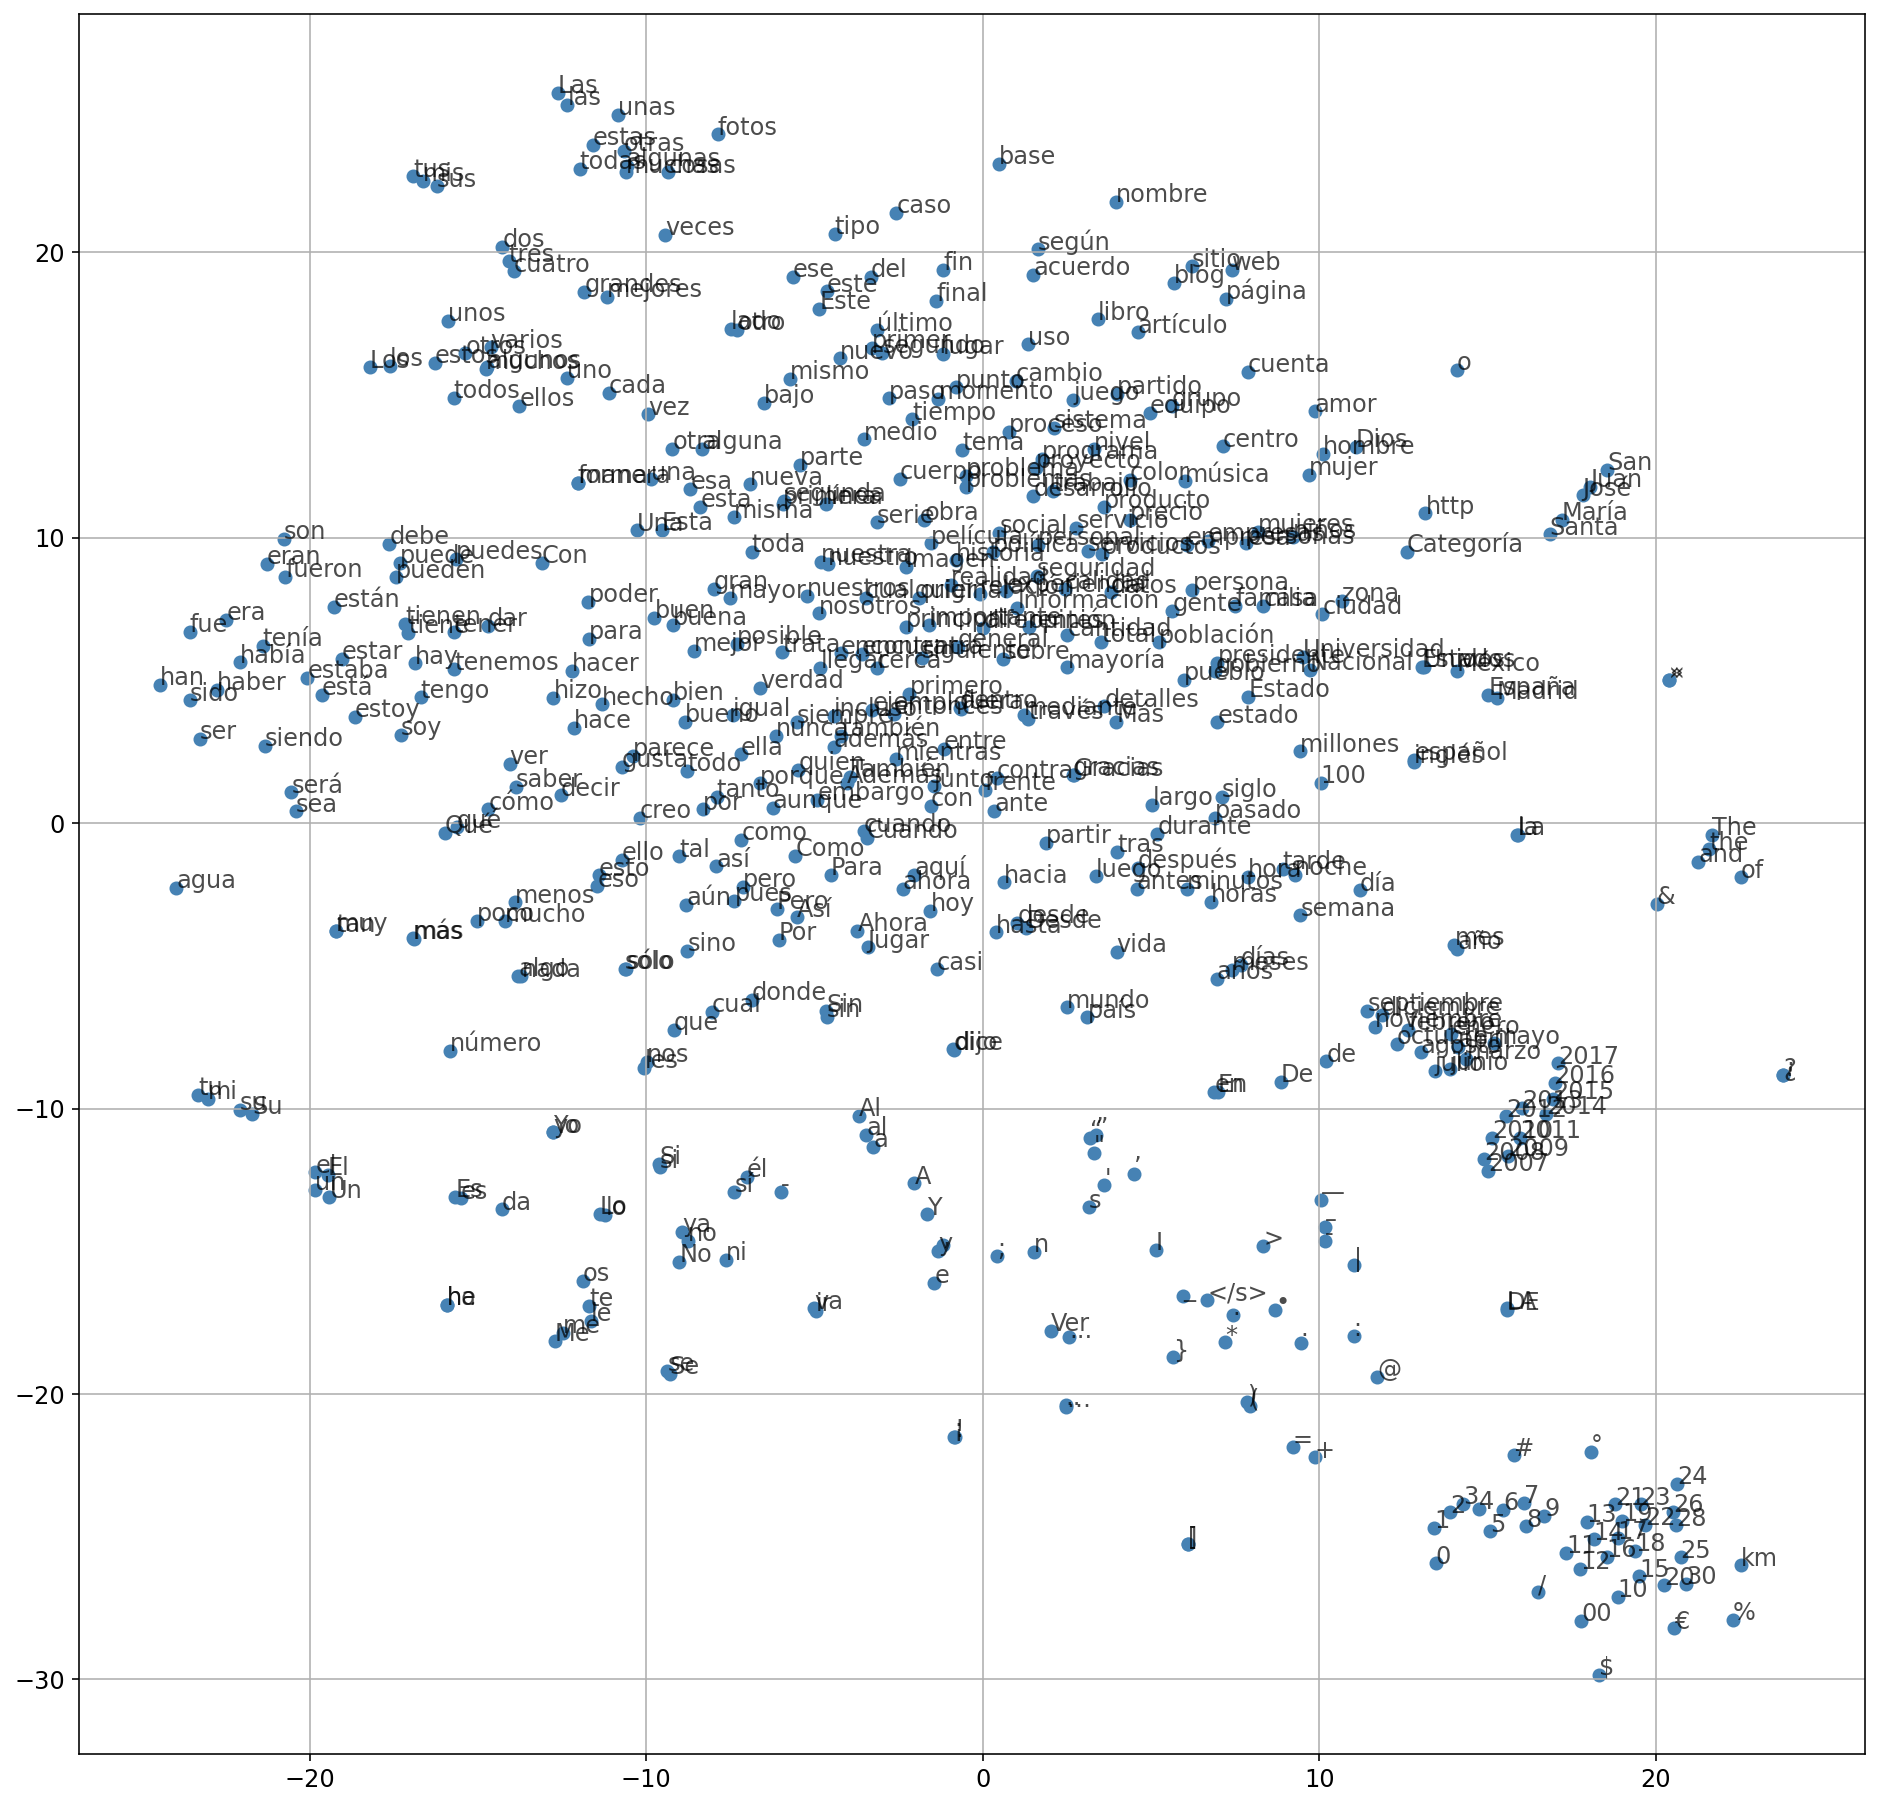

In [ ]:
# Dibujar solo 500 embeddings

fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(ft_es.wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
    
    
plt.grid()

Una vez cargado, podemos incluso re-entrenar el modelo con nuestros propios datos:

In [ ]:
new_sentences = [['Esta','es','la','nueva','frase']]

ft_es.build_vocab(new_sentences, update=True)
ft_es.train(new_sentences, total_examples=len(new_sentences), epochs=model.epochs)

(6, 25)

In [ ]:
# Liberemos memoria ...
del(ft_es)
gc.collect()

53323

**IMPORTANTE:** Si sólo queremos usar los word embeddings (incluso para palabras OOV), y no re-entrenar el modelo se recomienda usar la función `fasttext.load_facebook_vectors()` en lugar de `fasttext.load_facebook_model()`, ya que ésta únicamente carga los word-embeddings de las palabras/n-grams, consumiendo mucha menos CPU/RAM.

Finalmente, vamos a cargar un modelo en inglés para ver qué tal se compara con Wor2Vec en la base de datos Google Analogy. De nuevo, tarda un rato ...


In [ ]:
ft_en = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [ ]:
print(f"El tamaño del diccionario es {ft_en.vectors.shape[0]}. Cada embedding tiene una dimensión de {ft_en.vectors.shape[1]}")

El tamaño del diccionario es 999999. Cada embedding tiene una dimensión de 300


In [ ]:
df_red['3cosmul_FT'] = df_red[['Word a_','Word a','Word b']].apply(lambda row: analogy_3cosmul(ft_en,*row),axis=1)

df_red['correct_3cosmul_FT'] = df_red[['Word b_','3cosmul_FT']].apply(lambda row: es_correcto(*row),axis=1)


In [ ]:
print(f"El % de aciertos de la distancia 3cosmul con FT es {df_red['correct_3cosmul_FT'].sum()/df_red.shape[0]}")

El % de aciertos de la distancia 3cosmul con FT es 0.86


Podemos comprobar cómo fastText está mejorando sensiblemente a Word2Vec y gloVe en esta tarea en particular.

In [ ]:
# Liberemos memoria ...
del(ft_en)
gc.collect()

14

### FastText pre-entrenados en spaCy

Los distintos [pipelines accesibles a través de spaCy](https://spacy.io/models/en) incluyen también word embeddings pre-entrenados, muchos de ellos usando fastText:

In [ ]:
!python -m spacy download es_core_news_md

     |████████████████████████████████| 43.4 MB 4.6 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [ ]:
import spacy

# Cargamos el modelo
nlp = spacy.load("es_core_news_md") # Modelo de lenguaje en Español

lista_vocab = list(nlp.vocab.strings)

print("El tamaño del diccionario es de {} palabras".format(len(lista_vocab)))

#Las 100 primeras
print(lista_vocab[:100])

El tamaño del diccionario es de 703363 palabras
['\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x06\x06', '\x07', '\x07de', '\x07xx', '\x08', '\t', '\n', '\x0e', '\x0f', '\x10', '\x11', '\x12', '\x15', '\x16', '\x1a', '\x1a\x1a', '\x1c', '\x1d', '\x1e', '\x1f', ' ', '  ', ' el', ' tú', ' yo', ' él', '!', '!-', '!nk', '"', '"""', '")', '"-', '"--Especifica', '"--Xxxxx', '"--especifica', '"/', '"15', '"32', '"<br', '"<p', '"<xx', '">Esta', '">Xxxx', '">esta', '"A', '"Caño"', '"Con', '"Cuando', '"De', '"El', '"En', '"Es', '"Estamos', '"Este', '"Estoy', '"Guga"', '"Hay', '"La', '"Las', '"Lo', '"Los', '"Me', '"No', '"Para', '"Pero', '"Por', '"Se', '"Si', '"Steel"', '"Torito"', '"Tucho"', '"Un', '"Una', '"X', '"Xx', '"Xxx', '"Xxxx', '"Xxxx"', '"Xxxxx', '"Xxxxx"', '"Y', '"Yo', '"\\/', '"]=', '"a', '"añicos', '"caño"', '"con', '"cuando', '"de', '"el', '"en', '"es']


Podemos acceder de forma sencilla al word embedding de cada palabra:

In [ ]:
tokens = nlp("Estamos disfrutando del curso")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

Estamos True 34.566845 False
disfrutando True 24.894705 False
del True 50.092796 False
curso True 39.32992 False


In [ ]:
print(tokens[0].vector)

[-2.7080e-01  8.2935e-01  4.6736e-01 -1.7564e+00 -5.4847e-01 -7.3642e-01
 -1.5643e+00 -1.5346e-01 -1.3190e-01  1.1279e+00  2.0785e+00 -3.9641e-01
  2.0730e+00  4.0539e+00 -1.4848e+00 -1.3750e+00  2.3029e+00  2.3893e+00
  6.7918e-02 -1.1092e+00 -3.9791e+00  3.9074e-01 -3.1220e+00 -7.2981e-02
  2.3858e-01  1.1859e+00  4.1528e-01 -2.4936e-01  1.9408e+00  4.3501e+00
  2.1587e+00  1.6751e+00 -2.3294e+00 -1.1232e+00  7.7021e-01 -4.0510e+00
  1.4441e+00  4.5068e-01 -1.1928e+00  2.0493e-01 -2.5072e-01  7.5356e-01
  1.4124e+00 -2.8572e+00 -2.0372e+00 -7.0788e-01  3.0671e+00 -1.1842e+00
  3.7502e+00  1.1363e-01  4.9853e+00  1.8054e+00  9.0477e-01  2.2088e+00
  8.7899e-01  2.0216e+00 -1.2785e+00  7.9472e-01 -1.7526e+00 -3.5643e-02
 -2.2619e-01 -2.1886e+00 -1.9413e+00  5.7737e-04 -3.7290e+00  2.1606e+00
 -1.8707e+00  1.2870e-01  9.6488e-01  2.2666e+00  2.7160e+00  1.2405e+00
  1.8246e+00  2.5080e+00 -1.0901e-01 -3.2021e-01 -2.4440e-01  1.5624e+00
  8.1103e-01  9.8344e-01  4.2424e-01  2.5679e+00  2

# 5. Embeddings de textos


Con word embeddings, hemos obtenido representaciones vectoriales de baja dimensión **a nivel de palabra** con estructura semántica. En este último apartado presentaremos técnicas sencillas para vectorizar textos cortos (oraciones/párrafos):

* Latent Semantic Analysis, que ya presentamos la sesión anterior.
* Combinaciones de word embeddings.
* Doc2Vec.

## 5.1 Latent Semantic Analysis

Utilizando la descomposición SVD de la matriz TF-IDF de una oración dentro de un corpus, podemos obtener una aproximación de cada oración un vector $\mathbf{g}_j, j=1,\ldots,n$ de dimensión $K$ utilizando las componentes asociadas a los 𝐾 valores singulares de mayor valor:

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/LSA.png' width=900 />

Vamos a retomar el corpus `reuters` y calcular similitudes entre oraciones usando LSA. Primero cargamos el dataset y obtenemos la matriz TF-IDF siguiendo el pipeline habitual.


In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 45.7 MB 307 kB/s eta 0:00:01     |█████████▉                      | 14.0 MB 3.1 MB/s eta 0:00:11
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
nlp = spacy.load("en_core_web_md")

# Procesamos cada documento por separado
doc_list = [nlp(document) for document in reuters_raw]


In [ ]:
# Concatenamos todas las oraciones
corpus_sent = [s for doc in doc_list for s in doc.sents if len(s)>1]


# Filtramos tokens de cada oración
norm_doc_sent = [[w for w in s if not w.is_stop and w.has_vector
                  and not w.is_punct and (w.is_alpha or w.is_digit)] for s in corpus_sent]

# Nos quitamos las oraciones vacías (tras filtrar toquens)

corpus_sent = [corpus_sent[i] for i in range(len(corpus_sent)) if len(norm_doc_sent[i])>0]

norm_doc_sent = [s for s in norm_doc_sent if len(s)>0]

# Pasamos a modo texto  (para combinar con Gensim)

norm_doc_sent_text = [[w.text.lower() for w in s] for s in norm_doc_sent]

"""
RESUMEN:

- corpus_sent: todas las oraciones sin fitrar en tipo de dato spacy.docs
- norm_doc_sent: todas las oraciones filtradas en tipo de dato "listas de spacy.tokens"
- norm_doc_sent_text: todas las oraciones filtradas en modo texto

"""


print(f"Hay un total de {len(corpus_sent)} oraciones.")

Hay un total de 4134 oraciones.


In [ ]:
D = gensim.corpora.Dictionary(norm_doc_sent_text)

n_tokens = len(D)

no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .8 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)

n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 1827 terms
First terms in the dictionary:
0 : 12
1 : 19
2 : 7
3 : china
4 : daily
5 : grain
6 : pct
7 : provinces
8 : said
9 : says


In [ ]:
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense, corpus2csc

corpus_bow = [D.doc2bow(doc) for doc in norm_doc_sent_text]

model = TfidfModel(corpus_bow)  

corpus_tfidf = model[corpus_bow]

n_tokens = len(D)
num_docs = len(corpus_bow)

# Convert TFIDF representacion
corpus_tfidf_dense = corpus2dense(corpus_tfidf, num_terms=n_tokens, num_docs=num_docs)

print(f"La dimensión de la matriz TF-IDF es {corpus_tfidf_dense.shape[0]} x {corpus_tfidf_dense.shape[1]}")

La dimensión de la matriz TF-IDF es 1827 x 4134


Dada la matriz TF-IDF, calculemos la descomposición SVD ...

In [ ]:
from scipy.sparse.linalg import svds  # Función para calcular la descomposición en valores singulares

K = 50 # Dimensión de bajo rango

U,S,V = svds(corpus_tfidf_dense, k=K)  
print(U.shape, S.shape, V.shape)

(1827, 50) (50,) (50, 4134)


In [ ]:
G=np.diag(S)@V

print(G.shape)

(50, 4134)


Cada una de las columnas de la matriz `G` es una representación vectorial de dimensión 50 de cada oración del corpus. Calculemos la matriz de similitudes usando la distancia coseno. Para ello, usamos la función [`cosine_similarity`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) de sklearn:

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

distancias = cosine_similarity(V.T)

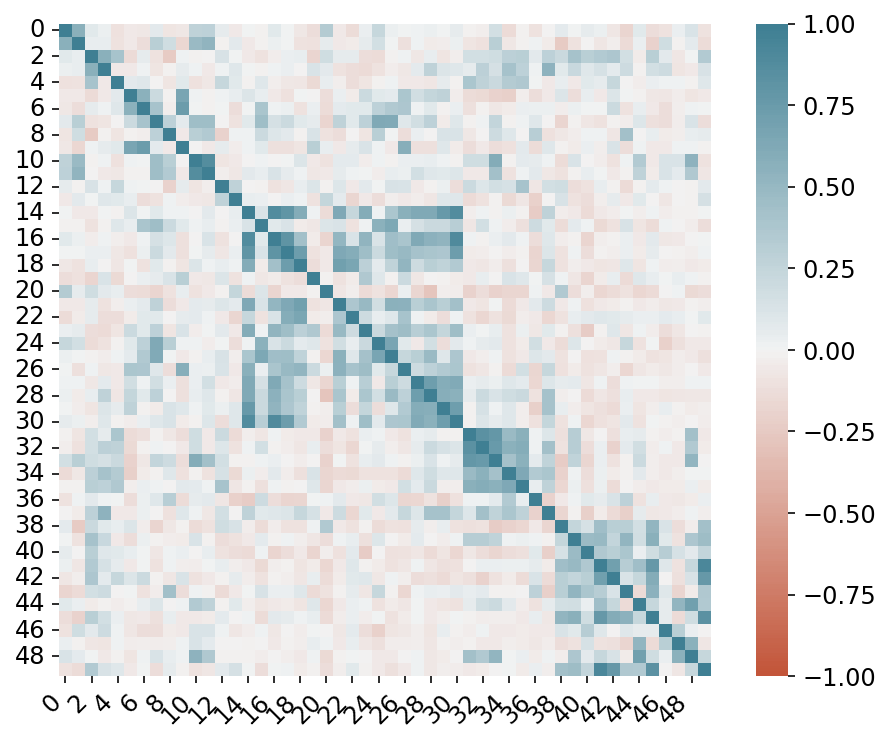

In [ ]:
# Visualicemo la matriz de similitudes de las 50 primeras oraciones 

ax = sns.heatmap(
    distancias[:50,:50], 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Finalmente podemos mostrar las 5 oraciones más similares a una dada:

In [ ]:
idx = 89

print(corpus_sent[idx].text)

print(f"\nLas 5 oraciones más similares son:\n")

idx_sim = np.argsort(-distancias[idx,:])

for i in range(6):
    if idx_sim[i] != idx:
        print(f"Oración {idx_sim[i]}\n")
        print(corpus_sent[idx_sim[i]].text)
        print('*****')


      It may buy the wheat, valued at 22.0 mln dlrs, between
  April 15 and August 31, 1987, and ship it from U.S. ports by
  September 30, the department said.

Las 5 oraciones más similares son:

Oración 1647


      It may buy the wheat flour, valued at 23.0 mln dlrs between
  April 8 and August 31, 1987 and ship it by September 30, the
  department said.
*****
Oración 3372


      It may buy the wheat, valued at 7.0 mln dlrs, between March
  25 and August 341 and ship it from U.S. ports and/or Canadian
  transshipment points by September 30, 1987.
*****
Oración 3934


      It may buy the rice, valued at 5.5 mln dlrs, between March
  31 and August 31, 1987, and ship it from U.S. ports by
  September 30, the department said.
*****
Oración 3246


      The department said it may buy the wheat, valued at 8.5 mln
  dlrs, the corn, valued at 1.5 mln, and the tallow, valued at
  2.0 mln dlrs, between March 24 and August 31, 1987, and ship it
  from U.S. ports and/or Canadian transshipme

Como vemos el resultado es razonable.

## 5.2 Combinaciones de word embeddings

Otra opción habitual para codificar un texto corto es utilizar la **media** de los word embeddings asociados a cada una de las palabras. Esta función está [directamente implementada en spaCy](https://spacy.io/usage/linguistic-features) cuando llamamos al método `.similarity` para calcular la similitud entre dos textos usando la distancia coseno entre las medias de los embeddings de cada uno de ellos: 

In [ ]:
idx = 89

# Usamos corpus_sent --> todas las oraciones (listas de spacy.Doc) sin filtrar tokens.

print(corpus_sent[idx])

print(f"\nLas 5 oraciones más similares son:\n")

distancias_a_idx = np.array([corpus_sent[idx].similarity(s) for s in corpus_sent])

idx_sim = np.argsort(-distancias_a_idx)

for i in range(6):
    if idx_sim[i] != idx:
        print(f"Oración {idx_sim[i]}\n")
        print(corpus_sent[idx_sim[i]])
        print('*****')


      It may buy the wheat, valued at 22.0 mln dlrs, between
  April 15 and August 31, 1987, and ship it from U.S. ports by
  September 30, the department said.

Las 5 oraciones más similares son:

Oración 3934


      It may buy the rice, valued at 5.5 mln dlrs, between March
  31 and August 31, 1987, and ship it from U.S. ports by
  September 30, the department said.
*****
Oración 1647


      It may buy the wheat flour, valued at 23.0 mln dlrs between
  April 8 and August 31, 1987 and ship it by September 30, the
  department said.
*****
Oración 3246


      The department said it may buy the wheat, valued at 8.5 mln
  dlrs, the corn, valued at 1.5 mln, and the tallow, valued at
  2.0 mln dlrs, between March 24 and August 31, 1987, and ship it
  from U.S. ports and/or Canadian transshipment points by this
  September 30.
*****
Oración 3372


      It may buy the wheat, valued at 7.0 mln dlrs, between March
  25 and August 341 and ship it from U.S. ports and/or Canadian
  transshipm

Podemos ver ahora cómo los vecinos más cercanos relatan noticias sobre la misma área geográfica (Túnez/Egipto) y sobre el mismo cereal (trigo).

En lugar de calcular la media los embedding, otra alternativa sería la [media ponderada utilizando los coeficientes TF-IDF](https://arxiv.org/pdf/1902.09875.pdf). 

**Nota importante sobre el método `Doc.similarity()`**


Como hemos visto método `similarity` es accesible a través de la clase `Doc` de spaCy. Este método se pierde cuando filtrado los tokens no deseados. Por ejemplo la lista `norm_doc_sent` se había generado como

```python
norm_doc_sent = [[w for w in s if not w.is_stop and w.has_vector
                  and not w.is_punct and (w.is_alpha or w.is_digit)] for s in corpus_sent]

norm_doc_sent_text = [[w.text.lower() for w in s] for s in norm_doc_sent]
```

y podemos ver que obtenemos un error al intentar utilizar el método `similarity` ...


In [ ]:
norm_doc_sent[0].similarity(norm_doc_sent[1])

AttributeError: 'list' object has no attribute 'similarity'

La opción más sencilla para volver a tener disponible este método, es generar de nuevo los strings a partir de los tokens

In [ ]:
norm_doc_sent_extended = [nlp(' '.join(q)) for q in norm_doc_sent_text]

In [ ]:
norm_doc_sent_extended[0].similarity(norm_doc_sent_extended[1])

0.8386437430755288

Usando `norm_doc_sent_extended` podemos encontrar las oraciones más simiares promediando sólo los embeddings de las palabras tras normalizar.

Alternativamente, podemos usar la opción [`spacy.tokens.doc.Doc()`](https://stackoverflow.com/questions/48169545/does-spacy-take-as-input-a-list-of-tokens), pero hay que pasar el diccionario y una secuencia que indica espacios entre tokens (necesaria para implementar algunas de las funcionalidades del pipeline de un modelo de lenguaje *spacy*). En este sentido la solución anterior parece más compacta.

## 5.3 Doc2Vec


Como se dijo, el objetivo de doc2vec es crear una representación numérica de un documento, independientemente de su longitud. Inspirado por Wor2Vec, [Doc2Vec](https://arxiv.org/pdf/1405.4053.pdf) aprende una representación vectorial de un párrafo/oración mediante un clasificador que predice la siguiente palabra dado una ventana de palabras anteriores y el vector asociado a dicho párrafo.

<img src='https://miro.medium.com/max/972/0*x-gtU4UlO8FAsRvL.' width=400 />


En la figura anterior, si estamos entrenando el modelo con 500 párrafos, entonces `Paragraph id` es una codifiación one-hot de 500 elementos para la cual queremos aprender una embedding real en un espacio de menor dimensión. Dados los embeddings del párrafo y de las palabras en una cierta ventana (3 palabras en la figura), entrenamos un clasificador tipo regresión logística para predecir la siguiente palabra del texto (*on* en la figura).


Tras entrenar el modelo, dado un nuevo párrafo, la representación vectorial de éste se obtiene mediante optimización numérica. Esto es, dada la salida del clasificador y las entradas correspondientes a las palabras, buscamos la codifiación del vector del párrafo que maximiza la probabilidad de la siguiente palabra. La función `model.infer_vector` implementa este proceso. 


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Con TaggedDocument, creamos un diccionario
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(norm_doc_sent_text)]

model = Doc2Vec(documents, vector_size=150,epochs=100)


Podemos ver la estructura de `documents`:

In [ ]:
documents

[TaggedDocument(words=['china', 'daily', 'says', 'vermin', 'eat', '7', '12', 'pct', 'grain', 'stocks', 'survey', '19', 'provinces', 'seven', 'cities', 'showed', 'vermin', 'consume', 'seven', '12', 'pct', 'china', 'grain', 'stocks', 'china', 'daily', 'said'], tags=[0]),
 TaggedDocument(words=['said', 'year', 'mln', 'tonnes', '25', 'pct', 'china', 'fruit', 'output', 'left', 'rot', 'mln', 'tonnes', '30', 'pct', 'vegetables'], tags=[1]),
 TaggedDocument(words=['paper', 'blamed', 'waste', 'inadequate', 'storage', 'bad', 'preservation', 'methods'], tags=[2]),
 TaggedDocument(words=['said', 'government', 'launched', 'national', 'programme', 'reduce', 'waste', 'calling', 'improved', 'technology', 'storage', 'preservation', 'greater', 'production', 'additives'], tags=[3]),
 TaggedDocument(words=['paper', 'gave', 'details'], tags=[4]),
 TaggedDocument(words=['thai', 'trade', 'deficit', 'widens', 'quarter', 'thailand', 'trade', 'deficit', 'widened', 'billion', 'baht', 'quarter', '1987', 'billion'

In [ ]:
idx = 89

# En model.docvecs.vectors_docs están los vectores de los documentos usados en entrenamiento
vector = model.docvecs.index_to_key[idx]

print(corpus_sent[idx])

print(f"\nLas 5 oraciones más similares son:\n")

most_sim = model.docvecs.most_similar([vector], topn=6)

for item in most_sim:
    idy = item[0]
    if idy != idx:
        print(f"Oración {idy}\n")
        print(corpus_sent[idy])
        print('*****')


      It may buy the wheat, valued at 22.0 mln dlrs, between
  April 15 and August 31, 1987, and ship it from U.S. ports by
  September 30, the department said.

Las 5 oraciones más similares son:

Oración 1647


      It may buy the wheat flour, valued at 23.0 mln dlrs between
  April 8 and August 31, 1987 and ship it by September 30, the
  department said.
*****
Oración 3934


      It may buy the rice, valued at 5.5 mln dlrs, between March
  31 and August 31, 1987, and ship it from U.S. ports by
  September 30, the department said.
*****
Oración 3246


      The department said it may buy the wheat, valued at 8.5 mln
  dlrs, the corn, valued at 1.5 mln, and the tallow, valued at
  2.0 mln dlrs, between March 24 and August 31, 1987, and ship it
  from U.S. ports and/or Canadian transshipment points by this
  September 30.
*****
Oración 3371

JAMAICA AUTHORIZED TO BUY PL 480 WHEAT - USDA
  Jamaica has been authorized to
  purchase about 56,000 tonnes of U.S. wheat under an existing P

/var/folders/mp/m1pxr4954g9dg7ypdlqgrgl800029_/T/ipykernel_1090/408999156.py:4: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vector = model.docvecs.index_to_key[idx]
/var/folders/mp/m1pxr4954g9dg7ypdlqgrgl800029_/T/ipykernel_1090/408999156.py:10: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  most_sim = model.docvecs.most_similar([vector], topn=6)


Por último, para obtener la representación vectorial de un nuevo documento utilizamos la función `model.infer_vector`:

In [ ]:
new_sentence = 'Brazil authorizes the sowing of GM drought resistant wheat. Brazil approves sowing and commercial activities for the drought resistant Bioceres’ HB4 wheat, reported the Brazilian Wheat Industry Association.'
print(new_sentence)

Brazil authorizes the sowing of GM drought resistant wheat. Brazil approves sowing and commercial activities for the drought resistant Bioceres’ HB4 wheat, reported the Brazilian Wheat Industry Association.


In [ ]:
new_sentence_norm = [w.text for w in nlp(new_sentence)]

In [ ]:
vector = model.infer_vector(new_sentence_norm)

In [ ]:
vector

array([-0.05616781,  0.00192044, -1.4108026 , -0.17141287, -0.32537258,
       -0.2483703 , -0.28331092,  0.51643467, -0.1294446 ,  0.14839104,
       -0.8761082 ,  0.3300197 ,  0.7304825 , -0.3286458 , -0.39827716,
        0.29329893, -0.40715343, -0.42856058, -0.28372163,  0.39222604,
       -0.05278586, -0.30024588, -0.3000409 , -0.75545317, -0.46873707,
       -0.16311651,  0.5408193 , -0.4742066 , -0.01033442, -0.5571125 ,
        0.09580237,  0.24298008,  0.25106734,  0.0673337 , -0.24291578,
        0.26002118,  0.267682  ,  0.35576272,  0.30413616, -0.5085599 ,
       -0.78655875,  0.56558245, -0.6941788 , -0.07796456,  0.43767518,
        0.37172925, -0.42812428, -0.18878867,  0.39617297,  0.47491682,
       -1.213443  ,  0.8056658 ,  0.28309056,  0.41753894, -0.06281758,
       -0.40105015, -0.45143977,  0.03856931, -0.16639304, -0.16596414,
       -0.6763223 , -0.69450784, -0.17610334, -0.10940832,  0.21788172,
        0.5291163 ,  0.61077034,  0.34316635,  0.2282955 ,  0.10